## CHEMENG 713/SEP 740 - Deep Learning - Final Project
--- Topic: CNN model for fruit and vegetable classification and feature analysis  
--- Group: No. 8  
--- Instructor: Dr. Sayyed Faridoddin Afzali  
--- Submission: Ping Li  
--- Data: Dec 18, 2023

### 1. Import libraries

In [ ]:
"""#############################################################################"""
# The following code is for run in google colab 

# import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/My Drive/Colab Notebooks/DL/Final_Project')
# sys.path.append('/content/drive/My Drive/Colab Notebooks/DL/Final_Project/Lib')
# sys.path.append('/content/drive/My Drive/Colab Notebooks/DL/Final_Project/Data')
"""#############################################################################"""

import os
import numpy as np
import torch
import copy
import cv2
import time
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms import v2
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchsummary import summary
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch.nn as nn  # Import the neural network module from PyTorch.
import torch.nn.functional as F  # Import the functional module from PyTorch for activation functions.
from torch.utils.data import DataLoader,TensorDataset, Dataset
from sklearn.model_selection import KFold

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Custom functions
--- package 1: for data prcessing, data management, ploting, and other functions  
--- package 2: for CNN architecture, and training function

##### - 2.1 Data processing functions

In [ ]:
# define function to load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert('RGB')
        if img is not None:
            images.append(np.array(img))
    return images

"""###########################################################################################################################"""

def label_image_data(image_data):
    """
    Preprocesses image data stored in a dictionary, converting it into NumPy arrays and assigning labels.

    Args:
    image_data (dict): A dictionary where keys are class names, and values are lists of image data.

    Returns:
    tuple: A tuple containing the following elements:
        - images (numpy.ndarray): NumPy array containing image data.
        - labels (numpy.ndarray): NumPy array containing corresponding integer labels.
        - label_mapping (dict): A dictionary mapping class names to their integer labels.
    """
    # Determine the total number of images
    total_images = sum(len(images) for images in image_data.values())

    # Create empty arrays with the correct shape to store the images and labels
    image_shape = image_data[list(image_data.keys())[0]][0].shape  # Get the shape of one image
    images = np.empty((total_images, *image_shape), dtype=np.uint8)
    labels = np.empty(total_images, dtype=np.int64)

    label_mapping = {}
    label_counter = 0
    image_counter = 0

    for class_name, image_list in image_data.items():
        label_mapping[class_name] = label_counter
        class_size = len(image_list)

        # Use NumPy slicing to assign image data directly to the images array
        images[image_counter:image_counter+class_size] = image_list

        # Assign labels directly to the labels array
        labels[image_counter:image_counter+class_size] = label_counter

        label_counter += 1
        image_counter += class_size

    return images, labels, label_mapping

"""###########################################################################################################################"""

def pick_samples(data, labels, label_mapping, num_samples_per_class=50, selected_classes=None):
    """
    Pick a portion of data evenly from specified classes and retrieve corresponding labels.
    Also returns a modified label mapping according to the desired classes.

    Args:
    data (numpy.ndarray): The data to select samples from.
    labels (numpy.ndarray): Labels corresponding to the data.
    num_samples_per_class (int): The number of samples to pick from each class. Default is 50.
    label_mapping (dict): Original mapping of labels to class names.
    selected_classes (list, optional): List of class indices to pick samples from. If None, selects from all classes.

    Returns:
    numpy.ndarray: Selected data samples.
    numpy.ndarray: Corresponding labels.
    dict: Modified label mapping for the selected classes.
    """
    if selected_classes is None:
        selected_classes = list(label_mapping.values())

    selected_data = []
    selected_labels = []

    for label in selected_classes:
        indices = np.where(labels == label)[0]
        class_count = len(indices)
        samples_to_pick = min(class_count, num_samples_per_class)
        selected_indices = np.random.choice(indices, samples_to_pick, replace=False)

        selected_data.append(data[selected_indices])
        selected_labels.extend([label] * samples_to_pick)

    # Create modified label mapping for selected classes
    modified_label_mapping = {class_name: index for class_name, index in label_mapping.items() if index in selected_classes}

    return np.vstack(selected_data), np.array(selected_labels), modified_label_mapping

"""###########################################################################################################################"""

class customDataset(Dataset):
    """
    Custom dataset class inherited from "torch.utils.data.Dataset"

    Parameters:
    - data (list or numpy array): The input data samples.
    - labels (list or numpy array): The corresponding labels for the data.
    - transform (callable, optional): A function/transform to apply to the data. Default is None.
    """

    def __init__(self, data, labels, transform=None):
        # Ensure that the length of data and labels is the same
        if len(data) != len(labels):
            raise ValueError("The length of data and labels must be the same")

        self.data = data
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        sample, label = self.data[index], self.labels[index]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.data)

"""###########################################################################################################################"""

def get_feature_maps(model, input_tensor):
    """
    Calculate feature maps for each convolutional layer in the CNN model.

    Parameters:
    - model (torch.nn.Module): The CNN model.
    - input_tensor (torch.Tensor): The input tensor (image).

    Returns:
    - List[torch.Tensor]: Feature maps from each convolutional layer.
    """
    feature_maps = []
    current_input = input_tensor.unsqueeze(0)  # Add batch dimension

    # Extract parameters from the convolutional layers
    kernels = [layer.weight.data for layer in model.convs]
    biases = [layer.bias.data for layer in model.convs]
    strides = [layer.stride for layer in model.convs]
    paddings = [layer.padding for layer in model.convs]

    # Define pooling operation based on the model's pooling_type
    if model.pooling_type == 'avg':
        pooling_function = F.avg_pool2d
    elif model.pooling_type == 'max':
        pooling_function = F.max_pool2d
    else:
        raise ValueError("Unknown pooling type")

    for i, layer in enumerate(model.convs):
        # Apply Convolution
        conv_output = F.conv2d(current_input, kernels[i], biases[i], strides[i], paddings[i])

        # Apply Activation Function (e.g., ReLU)
        conv_output = F.relu(conv_output)

        # Apply Pooling
        conv_output = pooling_function(conv_output, kernel_size=2)  # Assuming kernel size of 2 for pooling

        # Apply Dropout
        conv_output = F.dropout(conv_output, p=model.dropout_rate, training=False)

        feature_maps.append(conv_output)
        current_input = conv_output

    return feature_maps

"""###########################################################################################################################"""

def print_model_info(model, data_loader, loss_function, input_size=(3, 100, 100)):
    """
    Evaluates the model on a single batch from the data loader and prints the loss and model summary.

    Parameters:
    - model (nn.Module): The neural network model to evaluate.
    - data_loader (DataLoader): The PyTorch DataLoader to use for obtaining data.
    - loss_function (function): The loss function to use for calculating the model's loss.
    - input_size (tuple, optional): The size of the input images. Default is (3, 100, 100).
    """
    # Get a batch of data
    X, y = next(iter(data_loader))

    # Forward pass through the model
    yHat = model(X)

    # Print sizes of model outputs and target variable
    print('\nModel output shape:', yHat.shape)
    print('Target shape:', y.shape)

    # Compute and print the loss
    loss = loss_function(yHat, y)
    print('\nLoss:', loss.item())

    # Print the summary of the model
    print('\nModel Summary:')
    summary(model, input_size=input_size)

"""###########################################################################################################################"""

def plot_image_map(dataset, labels, label_mapping, num_columns=6):
    """
    Plots random images from each class in a grid.

    Args:
    dataset (list): A list of images.
    labels (numpy.ndarray): NumPy array containing integer labels corresponding to the images.
    label_mapping (dict): A dictionary mapping class names to their integer labels.
    num_columns (int): The number of columns for the grid. Default is 6.

    Returns:
    None
    """
    # Get a list of unique class labels
    unique_labels = list(label_mapping.values())

    # Calculate the number of rows needed based on the number of unique classes and columns
    num_rows = len(unique_labels) // num_columns + (len(unique_labels) % num_columns > 0)

    # Initialize a matplotlib figure for displaying the images
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(num_columns*2.4, num_rows*1.8))

    # Flatten the axs array to iterate through subplots
    axs = axs.flatten()

    # Iterate through unique class labels
    for i, label in enumerate(unique_labels):
        class_name = [class_name for class_name, l in label_mapping.items() if l == label][0]

        # Get all indices of images belonging to the current class
        class_indices = np.where(labels == label)[0]

        # Randomly select an image index from the class
        random_index = np.random.choice(class_indices)

        # Get the image data and label
        image = dataset[random_index]
        image_label = labels[random_index]

        # Display the image along with class label and class name
        axs[i].imshow(image)
        axs[i].set_title(f"Class {image_label}: {class_name}")
        axs[i].axis('off')

    # Hide any remaining empty subplots
    for i in range(len(unique_labels), num_rows * num_columns):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

"""###########################################################################################################################"""

def plot_augmented_images(original_images, augmented_dataset, num_samples):
    fig, axs = plt.subplots(2, num_samples, figsize=(16, 4))

    for i in range(num_samples):
        imageAugm, _ = augmented_dataset[i]

        # Transpose the images to make them compatible with imshow
        original_image = original_images[i].permute(1, 2, 0).detach()
        augmented_image = imageAugm.permute(1, 2, 0).detach()

        # Draw images
        axs[0, i].imshow(original_image)
        axs[1, i].imshow(augmented_image)

        # Some niceties
        for row in range(2):
            axs[row, i].set_xticks([])
            axs[row, i].set_yticks([])

    # Row labels
    axs[0, 0].set_ylabel('Original')
    axs[1, 0].set_ylabel('Augmented')

    plt.show()

"""###########################################################################################################################"""

def plot_feature_maps(feature_maps, num_cols=10):
    """
    Plot all feature maps from multiple layers.

    Parameters:
    - feature_maps (list of torch.Tensor): A list where each element is a tensor of feature maps from one layer.
    - num_cols (int): Number of columns in the subplot.
    """
    for layer_idx, layer_maps in enumerate(feature_maps):
        layer_maps = layer_maps.squeeze().unsqueeze(3) # Move the channel axis to the last dimension
        num_maps = layer_maps.size(0)  # Number of feature maps in this layer
        num_rows = (num_maps + num_cols - 1) // num_cols  # Calculate rows needed

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
        fig.suptitle(f'Layer {layer_idx + 1} Feature Maps {tuple(layer_maps.shape)}', fontsize=16)

        for i in range(num_maps):
            if num_rows == 1:  # If only one row, axes is a 1D array
                ax = axes[i % num_cols]
            else:  # Otherwise, axes is a 2D array
                ax = axes[i // num_cols, i % num_cols]

            ax.imshow(layer_maps[i])
            ax.axis('off')

        # Turn off any unused subplots
        for j in range(num_maps, num_rows * num_cols):
            if num_rows == 1:
                axes[j % num_cols].axis('off')
            else:
                axes[j // num_cols, j % num_cols].axis('off')

        plt.tight_layout()
        plt.show()

"""###########################################################################################################################"""

def plot_training_results(losses: list, train_acc: list, test_acc: list, final_test_acc: float):
    """
    Plots the training results including model losses and train/test accuracies.

    Parameters:
    losses (list of float): A list containing the loss values for each epoch.
    train_acc (list of float): A list containing the training accuracy for each epoch.
    test_acc (list of float): A list containing the test accuracy for each epoch.
    final_test_acc (float): The final test accuracy as a single float value.

    Returns:
    None: This function does not return anything but plots the training results.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # Plot for model losses
    ax[0].plot(losses, 's-')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Model Loss')

    # Plot for training and test accuracies
    ax[1].plot(train_acc, 's-', label='Train')
    ax[1].plot(test_acc, 'o-', label='Test')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].set_title(f'Final Model Test Accuracy: {final_test_acc:.2f}%')
    ax[1].legend()

    plt.show()

"""###########################################################################################################################"""

def image_contours_tensor(image_tensor):
    """
    Draws contours on an image represented as a PyTorch tensor.

    Parameters:
    - image_tensor (torch.Tensor): The input image tensor.

    Returns:
    - torch.Tensor: The image tensor with contours drawn.
    """
    # Convert the tensor to a NumPy array and change order from (C, H, W) to (H, W, C)
    image_np = image_tensor.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Existing code for contour detection...
    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image_np = image_np.copy()
    cv2.drawContours(contour_image_np, contours, -1, (0, 0, 255), 2)

    # Convert the NumPy array back to a tensor
    contour_image_tensor = torch.from_numpy(contour_image_np).float() / 255
    contour_image_tensor = contour_image_tensor.permute(2, 0, 1)  # Convert back to (C, H, W)

    return contour_image_tensor

"""###########################################################################################################################"""

def fill_uniform_color(image, color=(0, 0, 255)):  # Default color is blue
    """
    Fill all non-white areas of the input image with a specified uniform color.

    Parameters:
    - image (numpy.ndarray or torch.Tensor): The input image with a white background.
    - color (tuple): The RGB color to fill the image with, default is blue.

    Returns:
    - The processed image, with non-white areas filled with the specified color.
    """
    was_tensor = False

    # Check if the input is a PyTorch tensor
    if isinstance(image, torch.Tensor):
        was_tensor = True
        # Convert to NumPy array and change order from (C, H, W) to (H, W, C)
        image = image.permute(1, 2, 0).numpy()

    # creates a mask where the white areas are black and all other colors are white.
    mask = cv2.inRange(image, np.array([240, 240, 240]), np.array([255, 255, 255]))
    # inverts this mask, so fruit areas are white and the background is black.
    mask_inv = cv2.bitwise_not(mask)

    # This creates a new image array fruit_colored with the same shape as the input image
    # and fills it entirely with the specified color.
    colored_image = np.full_like(image, color)
    # This line uses the inverted mask mask_inv created in the previous steps to identify
    # the background pixels (which are now black in the inverted mask). It then sets these
    # background pixels in fruit_colored to white ([255, 255, 255] in RGB).
    # The condition mask_inv == 0 selects all pixels where mask_inv is black,
    # which corresponds to the background in the original image.
    colored_image[mask_inv == 0] = [255, 255, 255]

    # Convert back to tensor if original input was a tensor
    if was_tensor:
        colored_image = torch.from_numpy(colored_image).permute(2, 0, 1).float() / 255

    return colored_image


##### - 2.2 CNN functions

In [ ]:
class FlexiCNN(nn.Module):
    def __init__(self, n_classes: int, conv_config: list, fc_config: list,
                 input_size: tuple = (3, 224, 224), pooling: str = 'avg',
                 dropout_rate: float = 0.5, info: bool = False):
        """
        Initialize the FlexiCNN model with configurable convolutional and fully connected layers,
        including dropout for regularization.

        Parameters:
        - n_classes (int): Number of output classes.
        - conv_config (list): Configuration for convolutional layers, each element is a tuple of
                              (filters, kernel_size, stride, padding).
        - fc_config (list): Configuration for fully connected layers, where each element is the number
                            of neurons in the layer.
        - input_size (tuple, optional): Shape of input images (channels, height, width).
        - pooling (str, optional): Type of pooling to use ('avg' or 'max'). Default is 'avg'.
        - dropout_rate (float, optional): Dropout rate for regularization. Default is 0.5.
        - info (bool, optional): If True, prints the output size at each layer.
        """
        super(FlexiCNN, self).__init__()
        self.info = info
        self.input_size = input_size
        self.pooling_type = pooling
        self.dropout_rate = dropout_rate
        self.pooling_functions = {
            'avg': F.avg_pool2d,
            'max': F.max_pool2d
        }

        # Convolution layers
        self.convs = nn.ModuleList()
        channels = input_size[0]
        for filters, kernel, stride, padding in conv_config:
            self.convs.append(nn.Conv2d(channels, filters, kernel, stride, padding))
            channels = filters

        # Dropout for convolutional layers
        self.conv_dropout = nn.Dropout2d(dropout_rate)

        # Flattening size calculation
        self.flat_size = self._compute_flat_size()

        # Fully connected layers
        fc_layers = [self.flat_size] + fc_config + [n_classes]
        self.fcs = nn.ModuleList()
        for in_feature, out_feature in zip(fc_layers[:-1], fc_layers[1:]):
            self.fcs.append(nn.Linear(in_feature, out_feature))

        # Dropout for fully connected layers
        self.fc_dropout = nn.Dropout(dropout_rate)

    def _compute_flat_size(self):
        """
        Compute the flattened size after the convolutional layers.
        This method is used to determine the number of input features for the first fully connected layer.

        Returns:
        - int: The size of the flattened layer.
        """
        with torch.no_grad():
            dummy = torch.zeros((1,) + self.input_size)
            for conv in self.convs:
                dummy = F.avg_pool2d(F.relu(conv(dummy)), 2)
            return int(np.prod(dummy.size()[1:]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the model.

        Parameters:
        - x (torch.Tensor): The input tensor to the network.

        Returns:
        - torch.Tensor: The output tensor of the network.
        """
        for i, conv in enumerate(self.convs):
            x = conv(x)
            x = F.relu(x)
            pooling_function = self.pooling_functions.get(self.pooling_type, F.avg_pool2d)
            x = pooling_function(x, 2)
            x = self.conv_dropout(x)  # Apply dropout after pooling
            if self.info: print(f'Conv {i + 1} output: {x.shape}')

        x = x.view(x.size(0), -1) # the view is to reshape the tensor to a flatten vector, the x.size(0) is the batch size
        if self.info: print('Flattened output:', x.shape)

        for i, fc in enumerate(self.fcs[:-1]):
            x = F.relu(fc(x))
            x = self.fc_dropout(x)  # Apply dropout before next FC layer
            if self.info: print(f'FC {i + 1} output: {x.shape}')

        x = self.fcs[-1](x)
        if self.info: print('Final output:', x.shape)

        return x

"""###########################################################################################################################"""

class AconvCNN(nn.Module):
    """
    A convolutional neural network (CNN) that replaces traditional pooling layers with convolutional layers.

    Attributes:
    - n_classes (int): Number of output classes.
    - conv_config (list): Configuration for convolutional layers, each element is a tuple of
                          (filters, kernel_size, stride, padding).
    - fc_config (list): Configuration for fully connected layers, each element is the number
                        of neurons in the layer.
    - input_size (tuple): Shape of the input images (channels, height, width).
    - dropout_rate (float): Dropout rate for regularization.
    - info (bool): If True, prints the output size at each layer.
    """
    def __init__(self, n_classes: int, conv_config: list, fc_config: list,
                 input_size: tuple = (3, 224, 224), dropout_rate: float = 0.5, info: bool = False):
        super(AconvCNN, self).__init__()
        self.info = info
        self.input_size = input_size
        self.dropout_rate = dropout_rate

        # Initialize convolution layers
        self.convs = nn.ModuleList()
        channels = input_size[0]
        for filters, kernel, stride, padding in conv_config:
            self.convs.append(nn.Conv2d(channels, filters, kernel, stride, padding))
            channels = filters

        # Initialize dropout for convolutional layers
        self.conv_dropout = nn.Dropout2d(dropout_rate)

        # Calculate flattening size after convolutional layers
        self.flat_size = self._compute_flat_size()

        # Initialize fully connected layers
        fc_layers = [self.flat_size] + fc_config + [n_classes]
        self.fcs = nn.ModuleList()
        for in_feature, out_feature in zip(fc_layers[:-1], fc_layers[1:]):
            self.fcs.append(nn.Linear(in_feature, out_feature))

        # Initialize dropout for fully connected layers
        self.fc_dropout = nn.Dropout(dropout_rate)

    def _compute_flat_size(self):
        """
        Compute the flattened size after the convolutional layers.
        """
        with torch.no_grad():
            dummy = torch.zeros((1,) + self.input_size)
            for conv in self.convs:
                dummy = F.relu(conv(dummy))
            return int(np.prod(dummy.size()[1:]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the model.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor of the network.
        """
        for i, conv in enumerate(self.convs):
            x = conv(x)
            x = F.relu(x)
            x = self.conv_dropout(x)
            if self.info: print(f'Conv {i + 1} output: {x.shape}')

        x = x.view(x.size(0), -1)
        if self.info: print('Flattened output:', x.shape)

        for i, fc in enumerate(self.fcs[:-1]):
            x = F.relu(fc(x))
            x = self.fc_dropout(x)
            if self.info: print(f'FC {i + 1} output: {x.shape}')

        x = self.fcs[-1](x)
        if self.info: print('Final output:', x.shape)

        return x

"""###########################################################################################################################"""

def train_model(model, train_loader, test_loader, optimizer, loss_function, num_epochs=30, patience=5):
    """
    Function to train and evaluate the CNN model, with early stopping feature.
    :param model: The CNN model to train.
    :param train_loader: DataLoader for training data.
    :param test_loader: DataLoader for test data.
    :param optimizer: Optimizer for the model.
    :param loss_function: Loss function used during training.
    :param num_epochs: Number of training epochs.
    :param patience: Number of epochs to wait for improvement before stopping.
    :return: Training and test accuracies and losses, and final overall accuracies.
    """
    train_acc, test_acc, losses = [], [], []
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        batch_losses, batch_acc = [], []
        for X, y in train_loader:
            y = torch.squeeze(y)
            y_hat = model(X)
            loss = loss_function(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_acc.append((torch.argmax(y_hat, axis=1) == y).float().mean().item())

        train_acc.append(100*np.mean(batch_acc))
        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)

        # Early stopping check
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict()) # save the model need to 'import copy'
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered at {epoch+1} epoches')
                model.load_state_dict(best_model_wts)
                early_stop = True
                break

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            X, y = next(iter(test_loader))
            y = torch.squeeze(y)
            y_hat = model(X)
            test_acc.append(100*(torch.argmax(y_hat, axis=1) == y).float().mean().item())

        if early_stop:
            break

    # Load best model weights if early stopping happened
    if early_stop:
        model.load_state_dict(best_model_wts)

    # Final overall evaluation
    model.eval()
    final_train_acc, final_test_acc = evaluate_model(model, train_loader), evaluate_model(model, test_loader)

    return model, train_acc, test_acc, losses, final_train_acc, final_test_acc


def evaluate_model(model, loader):
    """
    Evaluate the model on the given DataLoader.
    :param model: Trained model to evaluate.
    :param loader: DataLoader for either training or test dataset.
    :return: Accuracy of the model on the given dataset.
    """
    total_correct, total_samples = 0, 0
    with torch.no_grad():
        for X, y in loader:
            y = torch.squeeze(y)
            y_hat = model(X)
            total_correct += (torch.argmax(y_hat, axis=1) == y).float().sum().item()
            total_samples += y.size(0)

    return 100*(total_correct / total_samples)

"""###########################################################################################################################"""

def fine_tune_and_evaluate(model, train_loader, test_loader, num_epochs=5):
    """
    Fine-tune and evaluate the ResNet model.

    Parameters:
    - model: The ResNet model to be fine-tuned.
    - train_loader: DataLoader for the training dataset.
    - test_loader: DataLoader for the testing dataset.
    - num_epochs: Number of epochs to train.

    Returns:
    - epoch_losses: A list of average losses per epoch.
    - epoch_accuracies: A list of accuracies per epoch on the test dataset.
    """
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossfunc(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        epoch_losses.append(average_loss)

        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        epoch_accuracies.append(accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy}%')

    return epoch_losses, epoch_accuracies


### 3. Save image to NPZ (could skip)  
--- This step is to read the image and save the entire dataset in a .NPZ file to load for training purposes.  
--- If the image dataset is downloaded from Kaggle.com, please replace the 'dataset_path' to your load drive address and run this step  
--- Recommend to download the 'fruit_train.npz' file from the link below and skip this step to load the dataset directly
--- https://mega.nz/file/QKp3nKwJ#MsqiZBOiBBTfu0AdYZAT1nP7HLa1WwxcbObnM7TrGJI

In [ ]:
# replace the dataset_path with your local drive address
dataset_path = r'D:\study\McMaster\F2023\SEP 740 Deep Learning\final_project\data\train\train'
dataset_train = {}

for class_folder in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_folder_path):
        dataset_train[class_folder] = load_images_from_folder(class_folder_path)

In [ ]:
# this code save the image to numerical dataset 
np.savez_compressed('fruit_train.npz', **dataset_train)

### 4. Load data
--- load the data from .NPZ file  
--- labeling the data with sequential value 0, 1, 2...

In [ ]:
# load data from NPZ

# for runing on loacl drive, the 'fruit_train.npz' file need to be in the same folder with this code
fruit_dict = np.load('fruit_train.npz')

# # for runing on googole colab
# fruit_dict = np.load('/content/drive/My Drive/Colab Notebooks/DL/Final_Project/Data/fruit_train.npz')

# labeling image data
data, labels, label_mapping = label_image_data(fruit_dict)

print(data.shape)
print(labels.shape)
print(label_mapping)

(16854, 100, 100, 3)
(16854,)
{'Apple Braeburn': 0, 'Apple Granny Smith': 1, 'Apricot': 2, 'Avocado': 3, 'Banana': 4, 'Blueberry': 5, 'Cactus fruit': 6, 'Cantaloupe': 7, 'Cherry': 8, 'Clementine': 9, 'Corn': 10, 'Cucumber Ripe': 11, 'Grape Blue': 12, 'Kiwi': 13, 'Lemon': 14, 'Limes': 15, 'Mango': 16, 'Onion White': 17, 'Orange': 18, 'Papaya': 19, 'Passion Fruit': 20, 'Peach': 21, 'Pear': 22, 'Pepper Green': 23, 'Pepper Red': 24, 'Pineapple': 25, 'Plum': 26, 'Pomegranate': 27, 'Potato Red': 28, 'Raspberry': 29, 'Strawberry': 30, 'Tomato': 31, 'Watermelon': 32}


In [ ]:
# Plot an image map
plot_image_map(data, labels, label_mapping)

### 5. Data processing
--- save 30% data untouched for final model evaluation  
--- pick a portion of the data for training to save computational cost  
--- data visualization for all classes  

In [ ]:
# reserve data for final testing, keep these data untouched!
tot_train_data, reserved_data, tot_train_labels, reserved_labels \
        = train_test_split(data,labels,test_size=0.3,random_state=42)

print(f'total_train_data:{tot_train_data.shape}')
print(f'total_train_labels:{tot_train_labels.shape}')
print(f'reserved_data:{reserved_data.shape}')
print(f'reserved_labels:{reserved_labels.shape}')

total_train_data:(11797, 100, 100, 3)
total_train_labels:(11797,)
reserved_data:(5057, 100, 100, 3)
reserved_labels:(5057,)


In [ ]:
# pick a portion of data for computational efficiency
selected_data, selected_labels, modified_label_mapping = pick_samples(tot_train_data, tot_train_labels, label_mapping, 100)
print(modified_label_mapping,'\n')

# data visualization
plot_image_map(selected_data, selected_labels, modified_label_mapping, num_columns=6)

# data preprocession
# normalization to [0 1]
selected_dataNorm = selected_data / np.max(selected_data)
# move axis 'channel' axis to dimension [0] (CHW means channel Height Width)
selected_dataCHW = np.transpose(selected_dataNorm, (0, 3, 1, 2))

# convert to torch tensor and move 'channel' axis
data_tensor = torch.tensor(selected_dataCHW).float()
labels_tensor = torch.tensor(selected_labels).long()

print()
print(f'selected_data_tensor: {data_tensor.shape}')
print(f'selected_labels_tensor: {labels_tensor.shape}')

{'Apple Braeburn': 0, 'Apple Granny Smith': 1, 'Apricot': 2, 'Avocado': 3, 'Banana': 4, 'Blueberry': 5, 'Cactus fruit': 6, 'Cantaloupe': 7, 'Cherry': 8, 'Clementine': 9, 'Corn': 10, 'Cucumber Ripe': 11, 'Grape Blue': 12, 'Kiwi': 13, 'Lemon': 14, 'Limes': 15, 'Mango': 16, 'Onion White': 17, 'Orange': 18, 'Papaya': 19, 'Passion Fruit': 20, 'Peach': 21, 'Pear': 22, 'Pepper Green': 23, 'Pepper Red': 24, 'Pineapple': 25, 'Plum': 26, 'Pomegranate': 27, 'Potato Red': 28, 'Raspberry': 29, 'Strawberry': 30, 'Tomato': 31, 'Watermelon': 32} 




selected_data_tensor: torch.Size([3300, 3, 100, 100])
selected_labels_tensor: torch.Size([3300])


### 6. Testing CNN model
--- Build CNN model with tested hyperparameters  
--- Feature analysis on 'Color', 'Shape', and 'Texture'

#### - 6.1 Demo run without data augmentation

In [ ]:
# data split
train_data, test_data, train_labels,test_labels = train_test_split(data_tensor, labels_tensor, test_size=.3)
# convert to TensorDataset
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)
# send to DataLoader for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_d1_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(16, 7, 2, 1), (32, 5, 1, 1), (64, 5, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_d1 = FlexiCNN(**model_d1_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_d1, train_loader, lossfun, input_size=(3, 100, 100))

Conv 1 output: torch.Size([128, 16, 24, 24])
Conv 2 output: torch.Size([128, 32, 11, 11])
Conv 3 output: torch.Size([128, 64, 4, 4])
Flattened output: torch.Size([128, 1024])
Final output: torch.Size([128, 33])

Model output shape: torch.Size([128, 33])
Target shape: torch.Size([128])

Loss: 3.50250506401062

Model Summary:
Conv 1 output: torch.Size([2, 16, 24, 24])
Conv 2 output: torch.Size([2, 32, 11, 11])
Conv 3 output: torch.Size([2, 64, 4, 4])
Flattened output: torch.Size([2, 1024])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]           2,368
         Dropout2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 22, 22]          12,832
         Dropout2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 9, 9]          51,264
         Dropout2d-6    

Early stopping triggered at 28 epoches
Execution time: 26.9305 seconds



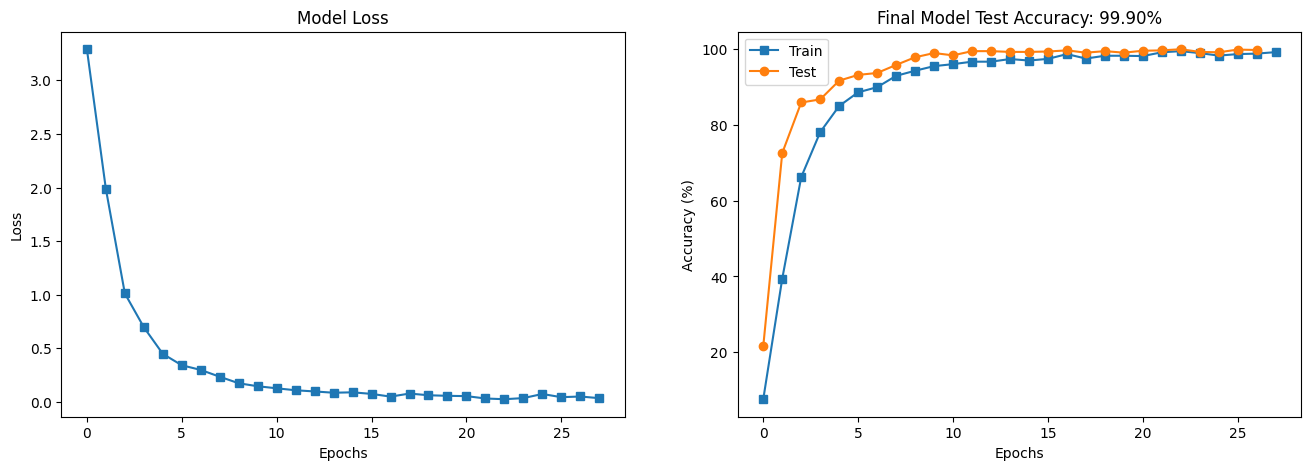

In [ ]:
# Run the demo model
# Create a new configuration with 'info' set to False
model_d1 = {**model_d1_info, "info": False}

# create the model
fruitCNN_d1 = FlexiCNN(**model_d1)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_d1.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }

# Train the model
start_time = time.time()  # Record the start time

net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_d1,
    train_loader,
    test_loader,
    **training_config)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time:.4f} seconds\n")

# Save the trianed net
fruitCNN_d1_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

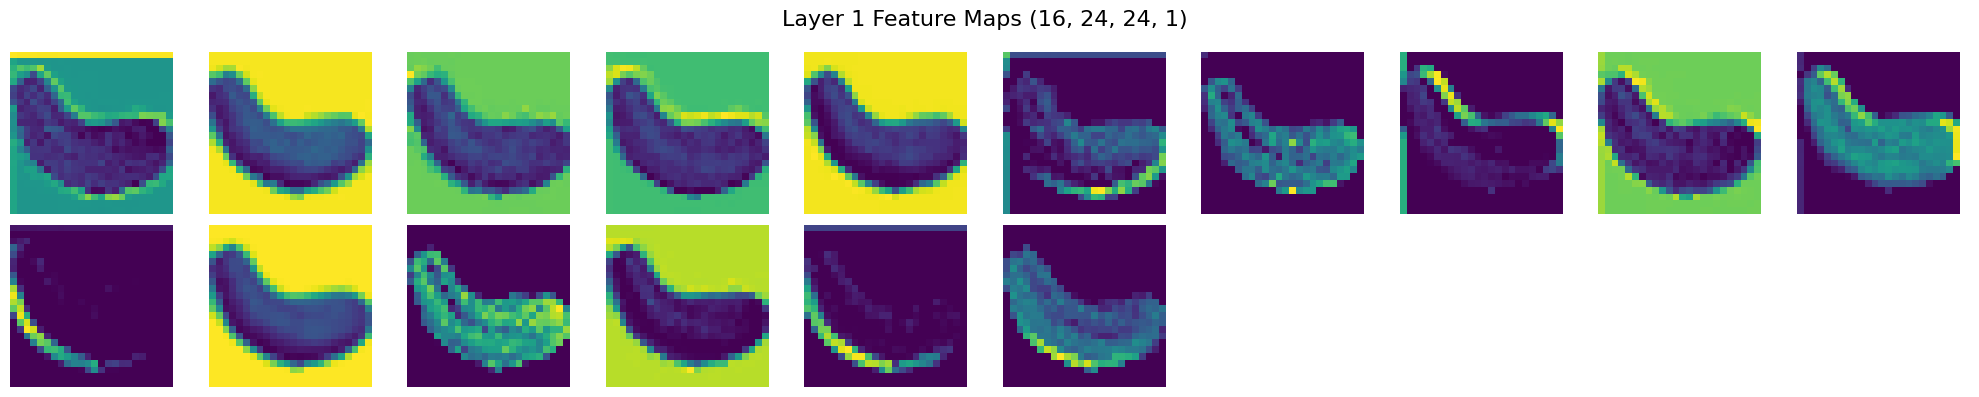

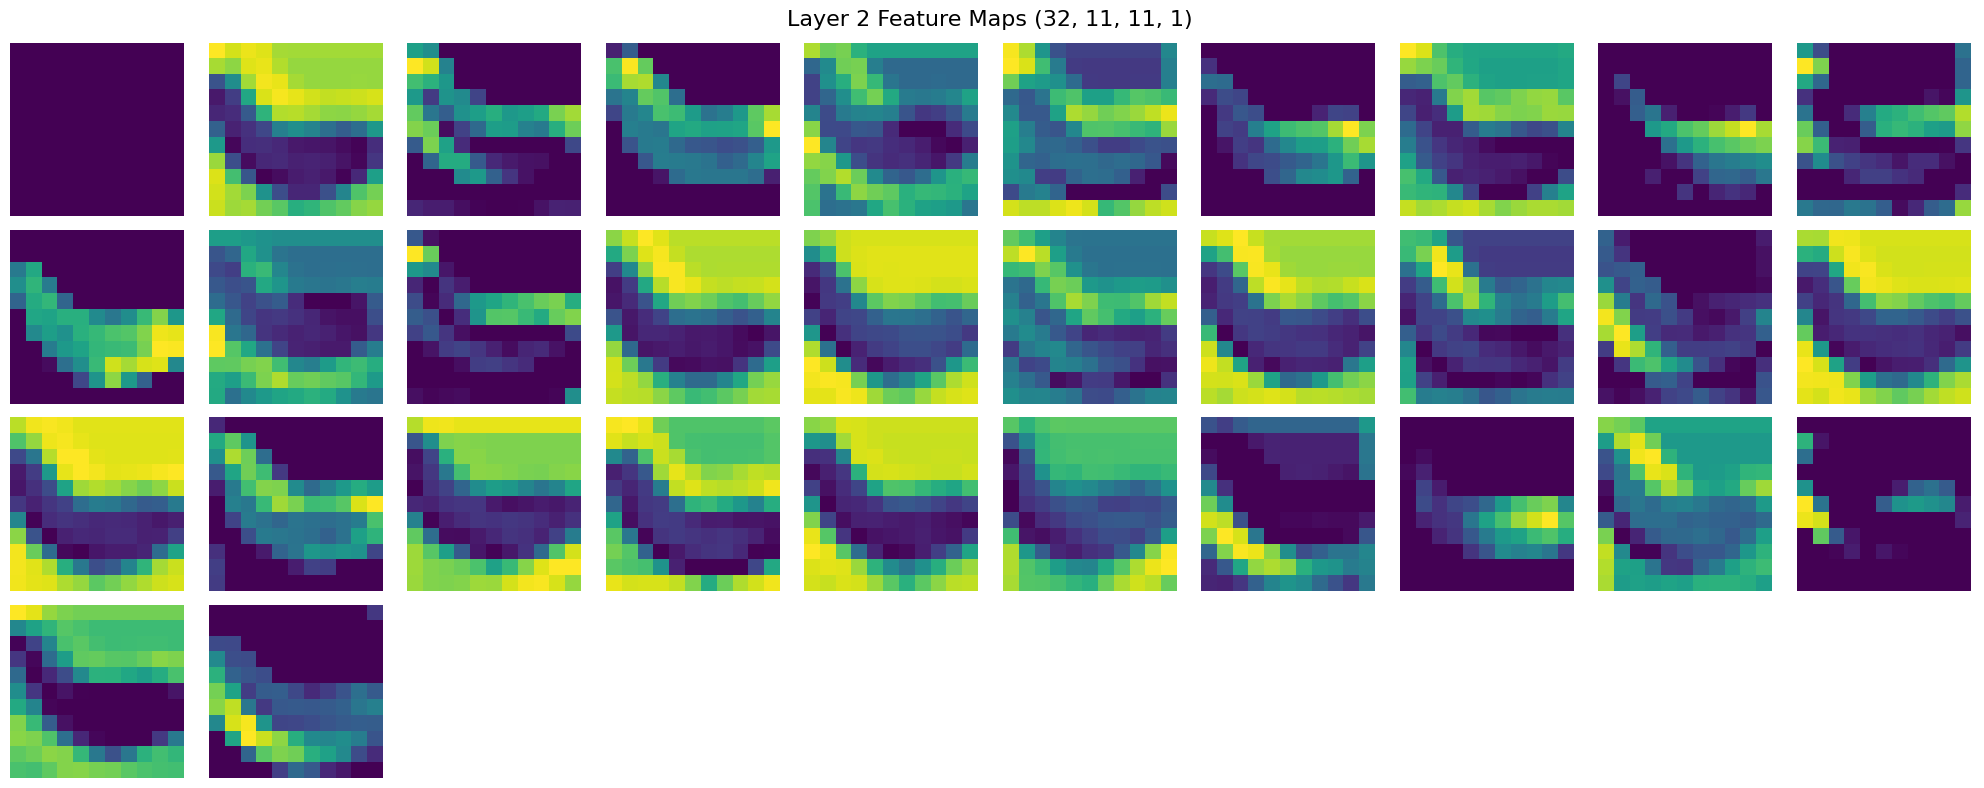

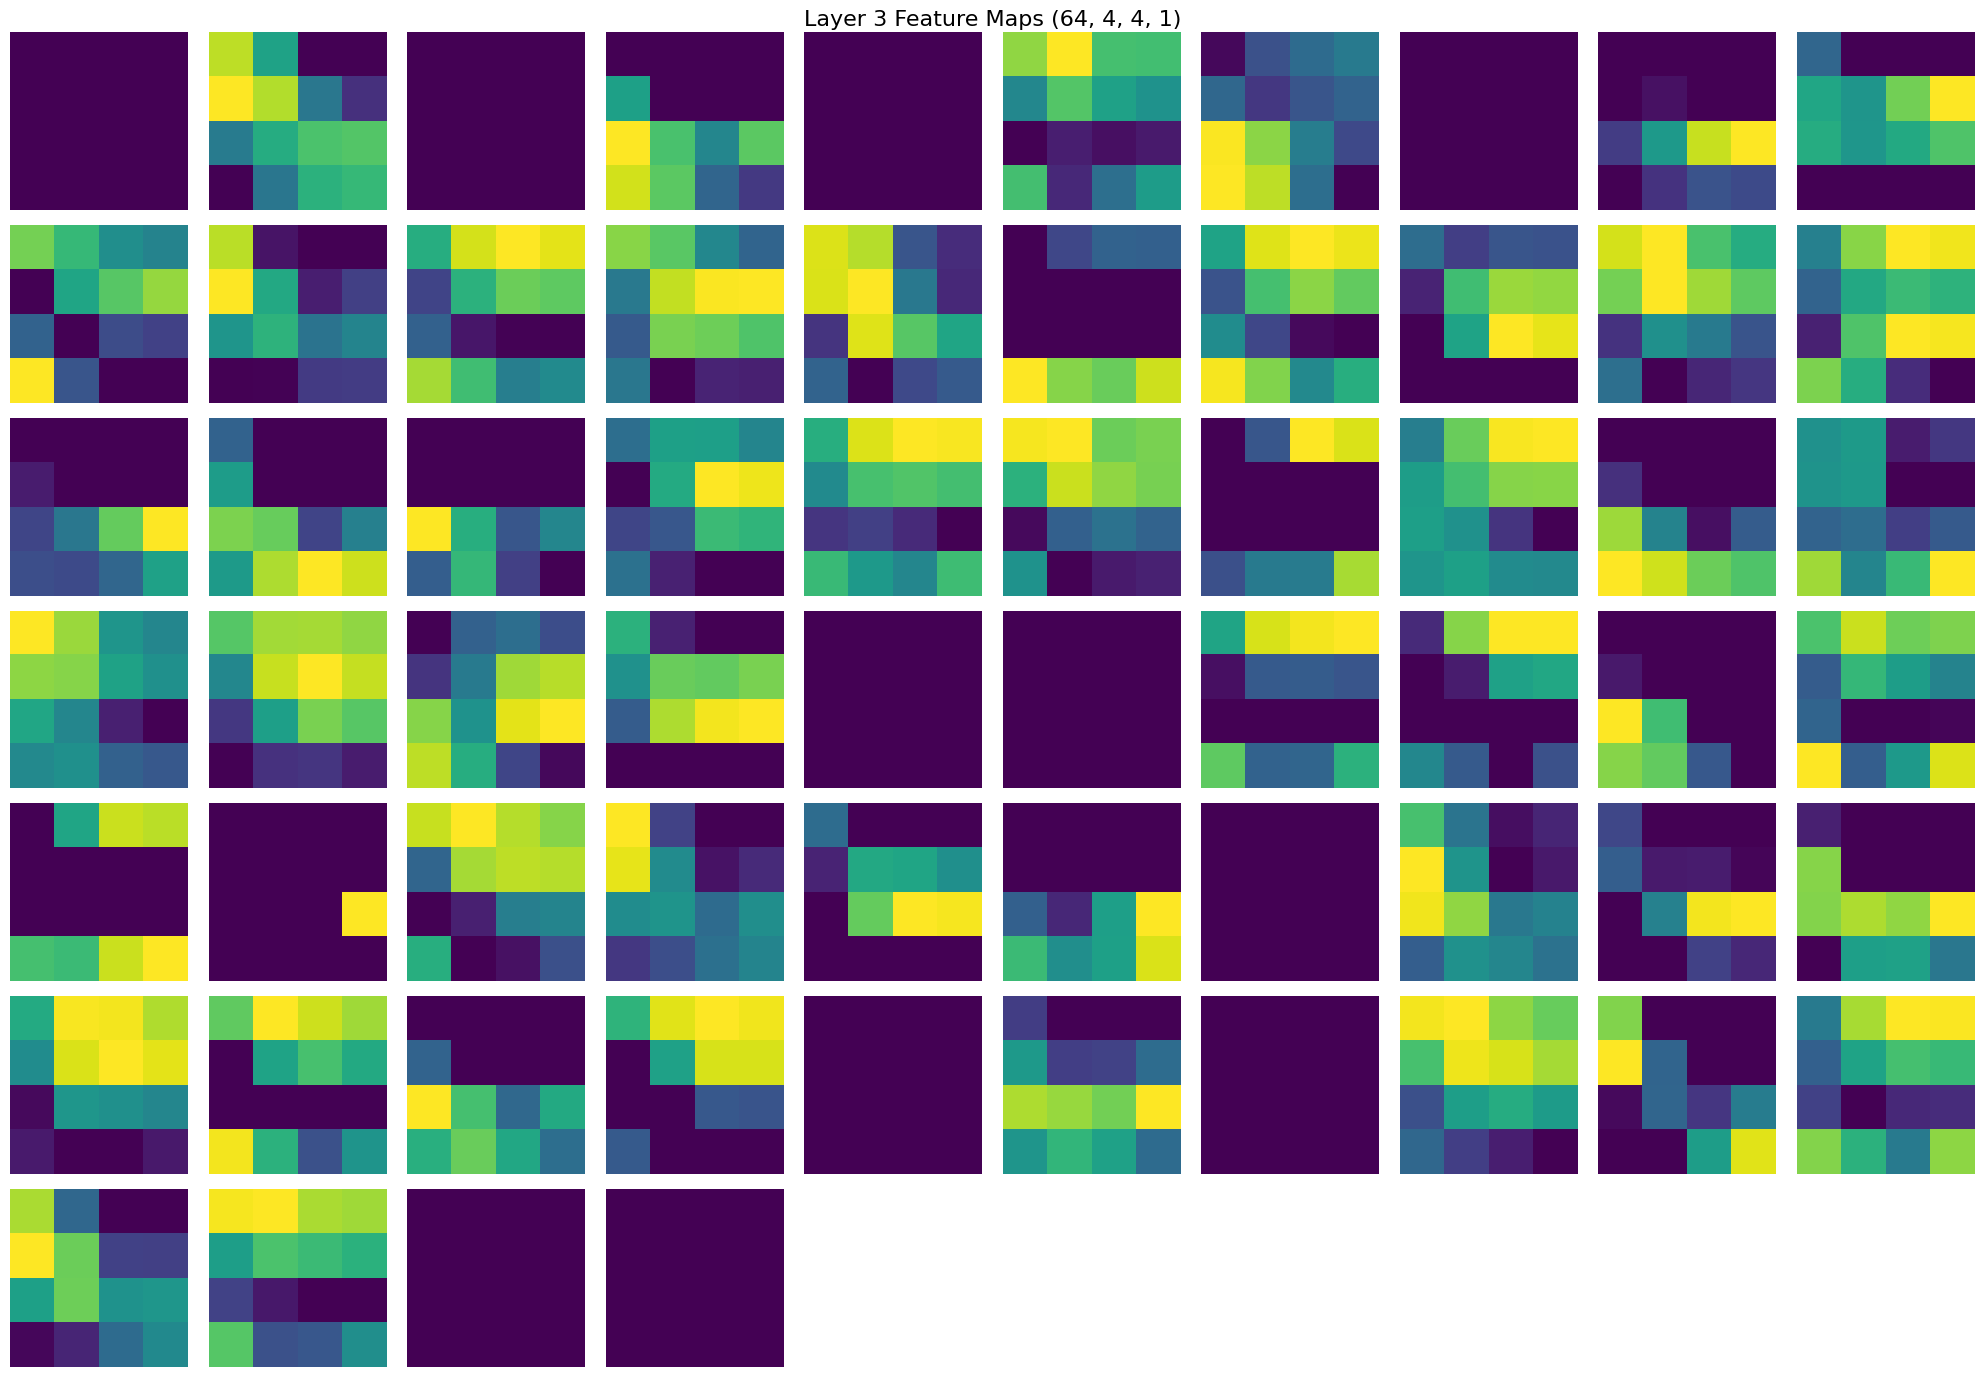

In [ ]:
# plot feature maps

# load trained model
d1_net = FlexiCNN(**model_d1)
d1_net.load_state_dict(fruitCNN_d1_trained)

# get feature maps for a image sample and plot it
feature_maps = get_feature_maps(d1_net, data_tensor[np.random.randint(0, len(data_tensor))])
plot_feature_maps(feature_maps)

#### - 6.2 Demo run with data augmentation
--- testing from shallow to deep convolution layers  
--- inlcuding 2, 3, 4, 5 cov layers

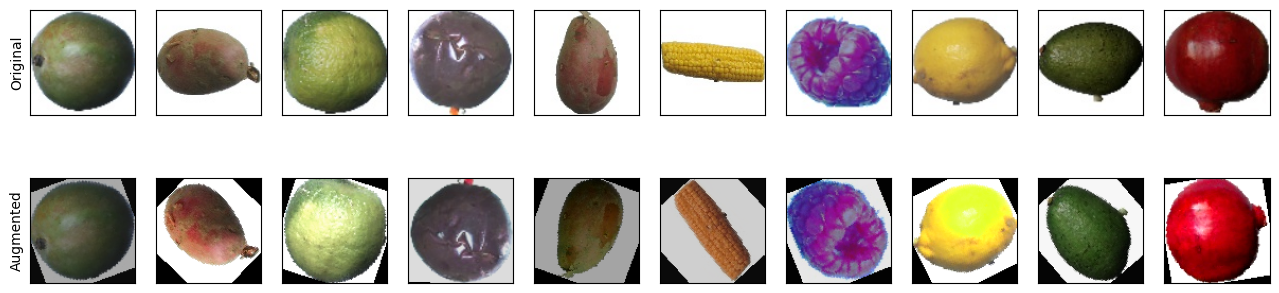

In [ ]:
# data augmentation
image_transform = v2.Compose([
    # v2.RandomResizedCrop(224),  # Randomly crops and resizes the image mainly for pretrained model
    v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
    ])

# select random images
num_samples = 10
index_rand = np.random.choice(len(data_tensor), num_samples, replace=False)
image_rand = data_tensor[index_rand]
label_rand = labels_tensor[index_rand]

# augmented images
image_augm = customDataset(image_rand, label_rand, transform=image_transform)
# plot the images
plot_augmented_images(image_rand, image_augm, num_samples)

##### -- 6.2.1 Testing on 2 CONV layers architecture

In [ ]:
# data split
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.3)
# data augmentation
train_data = customDataset(train_data, train_labels, transform=image_transform)
test_data  = customDataset(test_data, test_labels, transform=None)
# load data for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_d2_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(10, 7, 3, 1), (20, 5, 2, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_d2 = FlexiCNN(**model_d2_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_d2, train_loader, lossfun, input_size=(3, 100, 100))

Conv 1 output: torch.Size([128, 10, 16, 16])
Conv 2 output: torch.Size([128, 20, 3, 3])
Flattened output: torch.Size([128, 180])
Final output: torch.Size([128, 33])

Model output shape: torch.Size([128, 33])
Target shape: torch.Size([128])

Loss: 3.497020721435547

Model Summary:
Conv 1 output: torch.Size([2, 10, 16, 16])
Conv 2 output: torch.Size([2, 20, 3, 3])
Flattened output: torch.Size([2, 180])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]           1,480
         Dropout2d-2           [-1, 10, 16, 16]               0
            Conv2d-3             [-1, 20, 7, 7]           5,020
         Dropout2d-4             [-1, 20, 3, 3]               0
            Linear-5                   [-1, 33]           5,973
Total params: 12,473
Trainable params: 12,473
Non-trainable params: 0
-------------------------------------------

Early stopping triggered at 82 epoches
Execution time: 651.7570 seconds



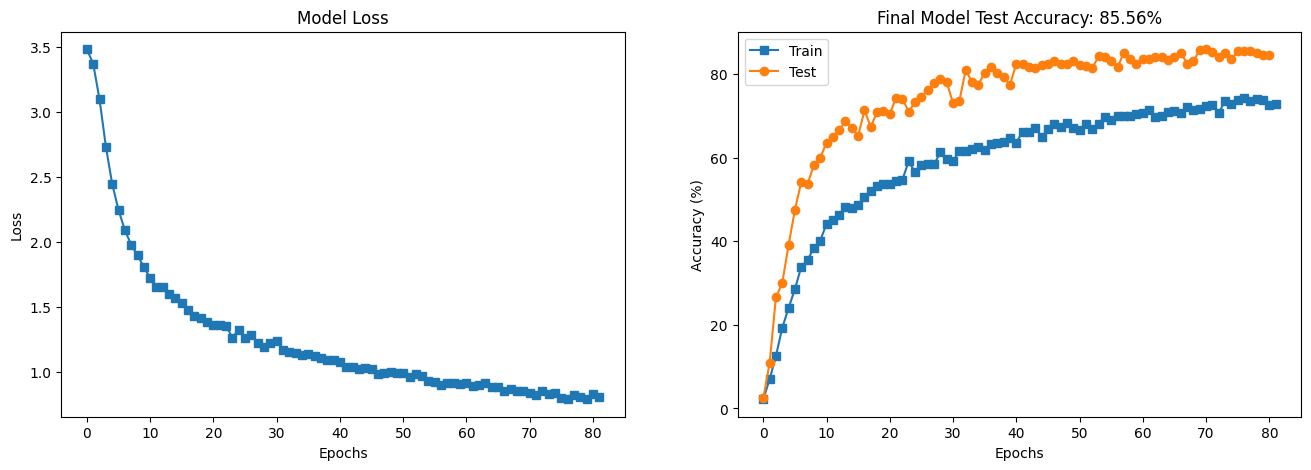

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_d2 = {**model_d2_info, "info": False}

# create the model
fruitCNN_d2 = FlexiCNN(**model_d2)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_d2.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model

start_time = time.time()  # Record the start time

net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_d2,
    train_loader,
    test_loader,
    **training_config)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time:.4f} seconds\n")

# Save the trianed net
fruitCNN_d2_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

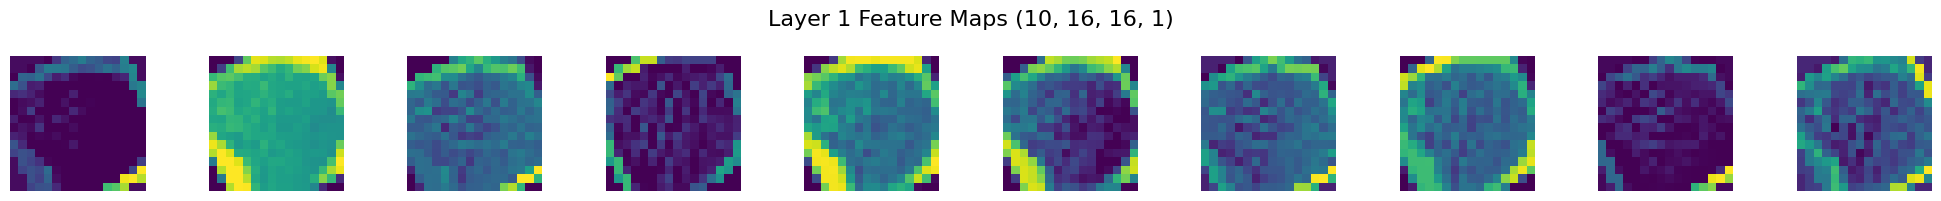

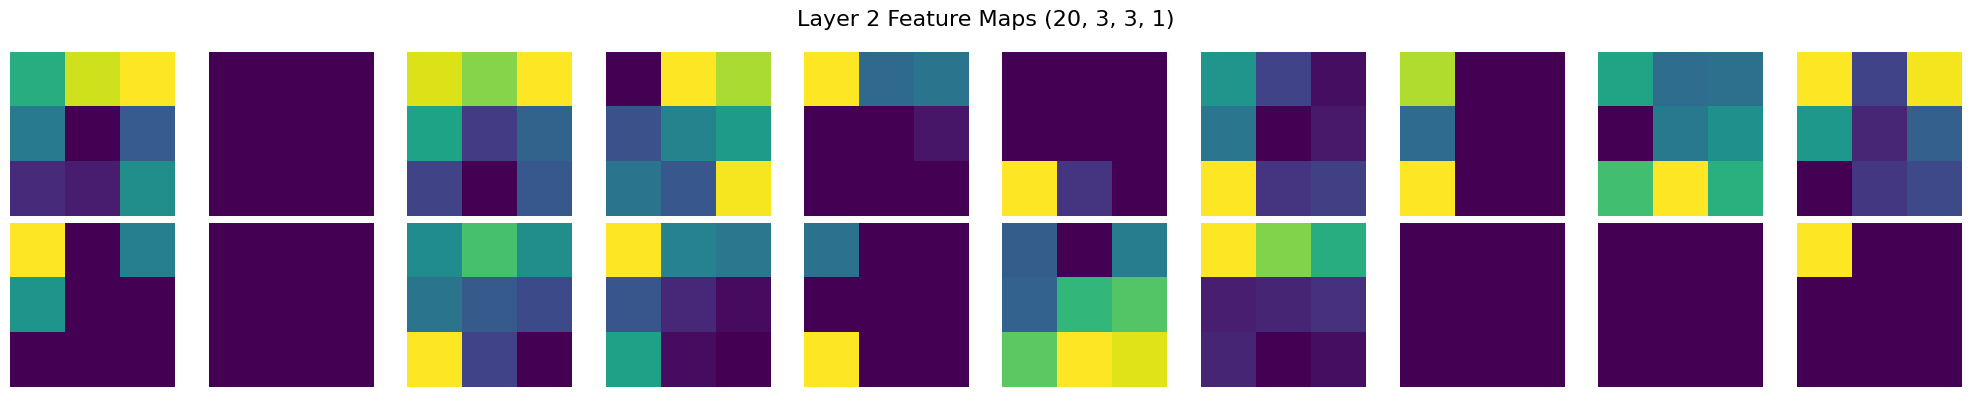

In [ ]:
# plot feature maps

# load trained model
d2_net = FlexiCNN(**model_d2)
d2_net.load_state_dict(fruitCNN_d2_trained)

# get feature maps for an image sample and plot it
augm_image = image_transform(data_tensor[np.random.randint(0, len(data_tensor))])
feature_maps = get_feature_maps(d2_net, augm_image)
plot_feature_maps(feature_maps)

##### -- 6.2.2 Testing on 3 CONV layers architecture

In [ ]:
# data split
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.3)
# data augmentation
train_data = customDataset(train_data, train_labels, transform=image_transform)
test_data  = customDataset(test_data, test_labels, transform=None)
# load data for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_d3_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(16, 7, 2, 1), (32, 5, 1, 1), (64, 5, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_d3 = FlexiCNN(**model_d3_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_d3, train_loader, lossfun, input_size=(3, 100, 100))

Conv 1 output: torch.Size([128, 16, 24, 24])
Conv 2 output: torch.Size([128, 32, 11, 11])
Conv 3 output: torch.Size([128, 64, 4, 4])
Flattened output: torch.Size([128, 1024])
Final output: torch.Size([128, 33])

Model output shape: torch.Size([128, 33])
Target shape: torch.Size([128])

Loss: 3.4942052364349365

Model Summary:
Conv 1 output: torch.Size([2, 16, 24, 24])
Conv 2 output: torch.Size([2, 32, 11, 11])
Conv 3 output: torch.Size([2, 64, 4, 4])
Flattened output: torch.Size([2, 1024])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]           2,368
         Dropout2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 22, 22]          12,832
         Dropout2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 9, 9]          51,264
         Dropout2d-6  

Early stopping triggered at 86 epoches
Execution time: 714.8723 seconds



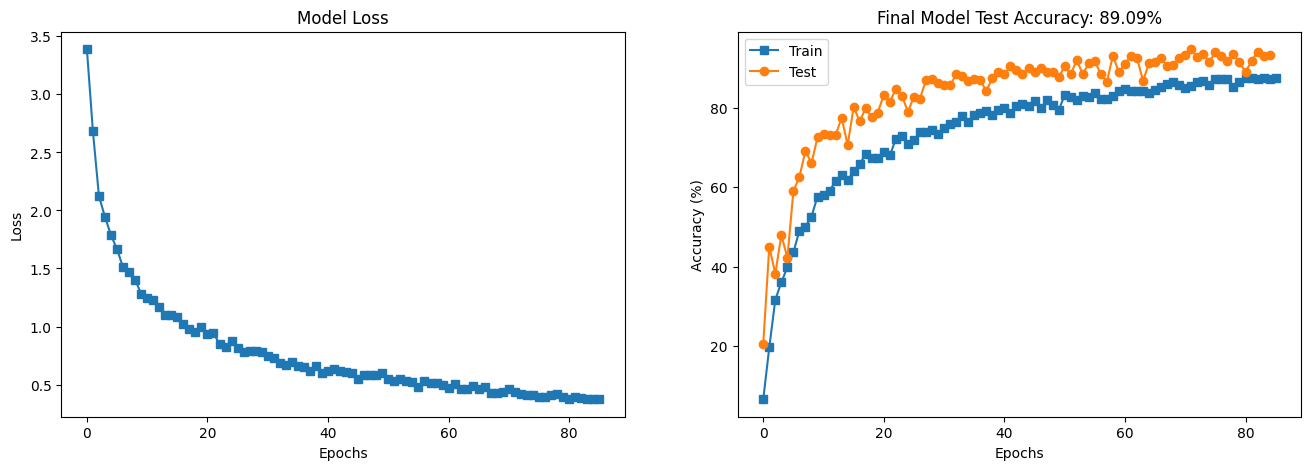

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_d3 = {**model_d3_info, "info": False}

# create the model
fruitCNN_d3 = FlexiCNN(**model_d3)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_d3.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model

start_time = time.time()  # Record the start time

net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_d3,
    train_loader,
    test_loader,
    **training_config)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time:.4f} seconds\n")

# Save the trianed net
fruitCNN_d3_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

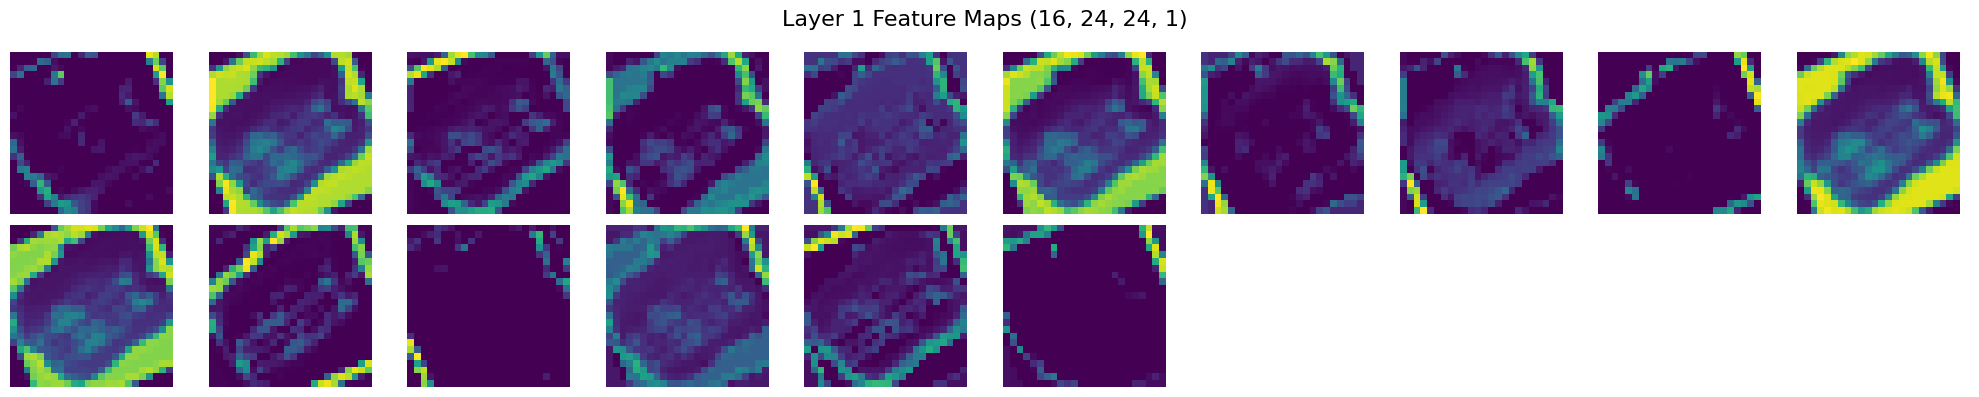

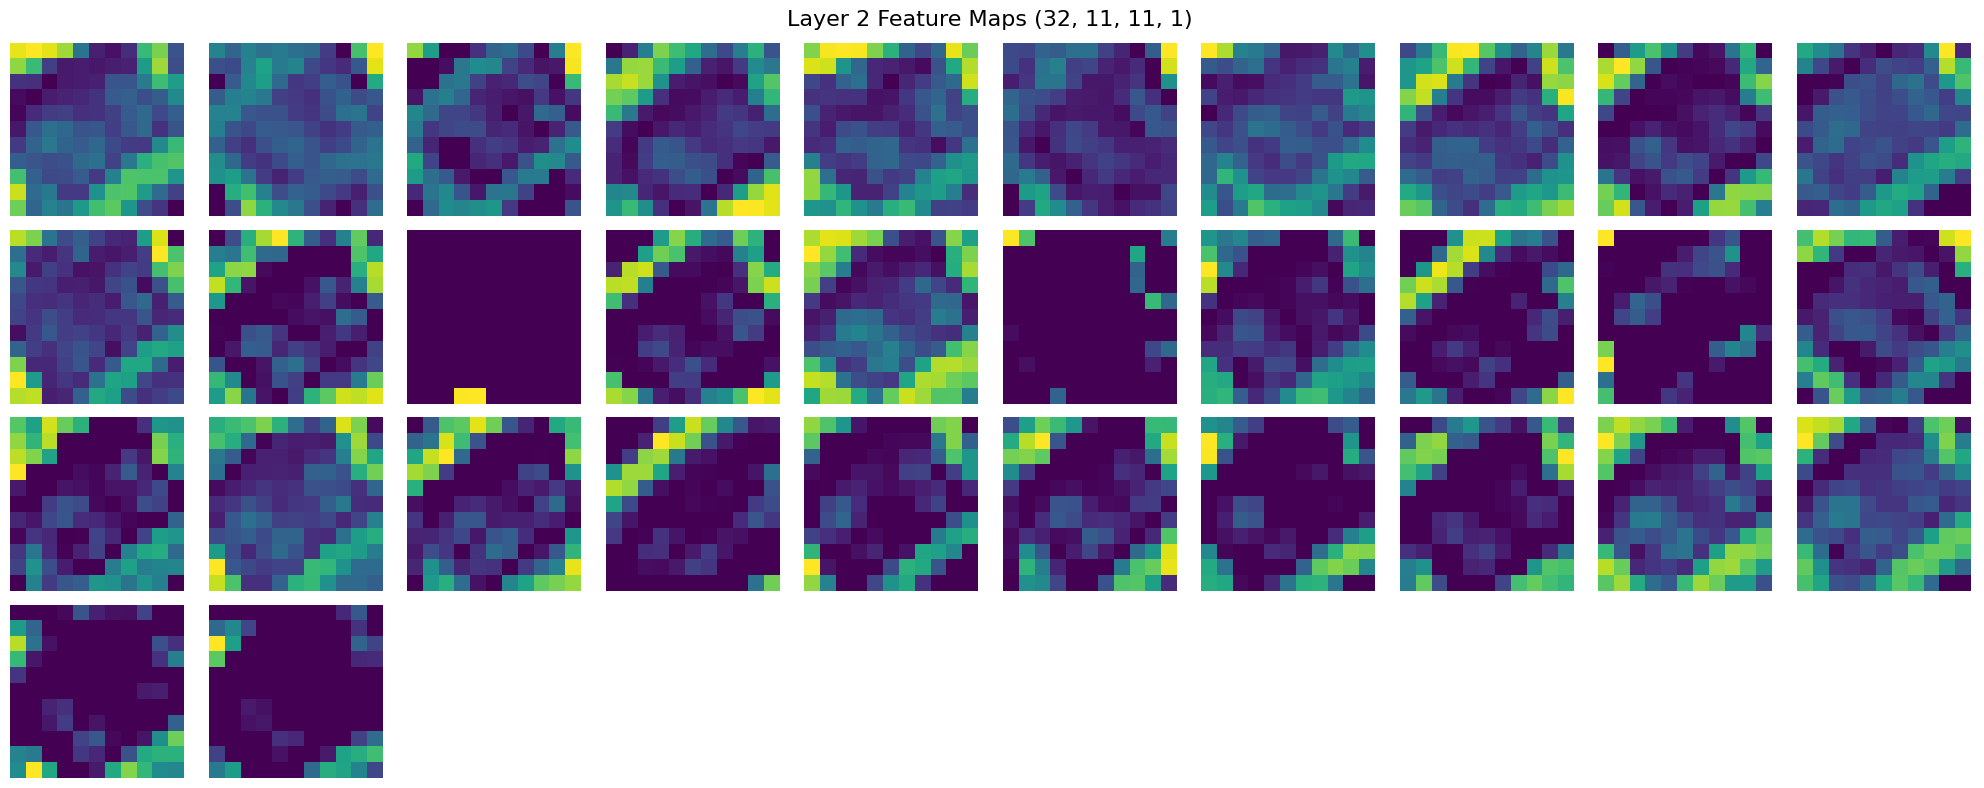

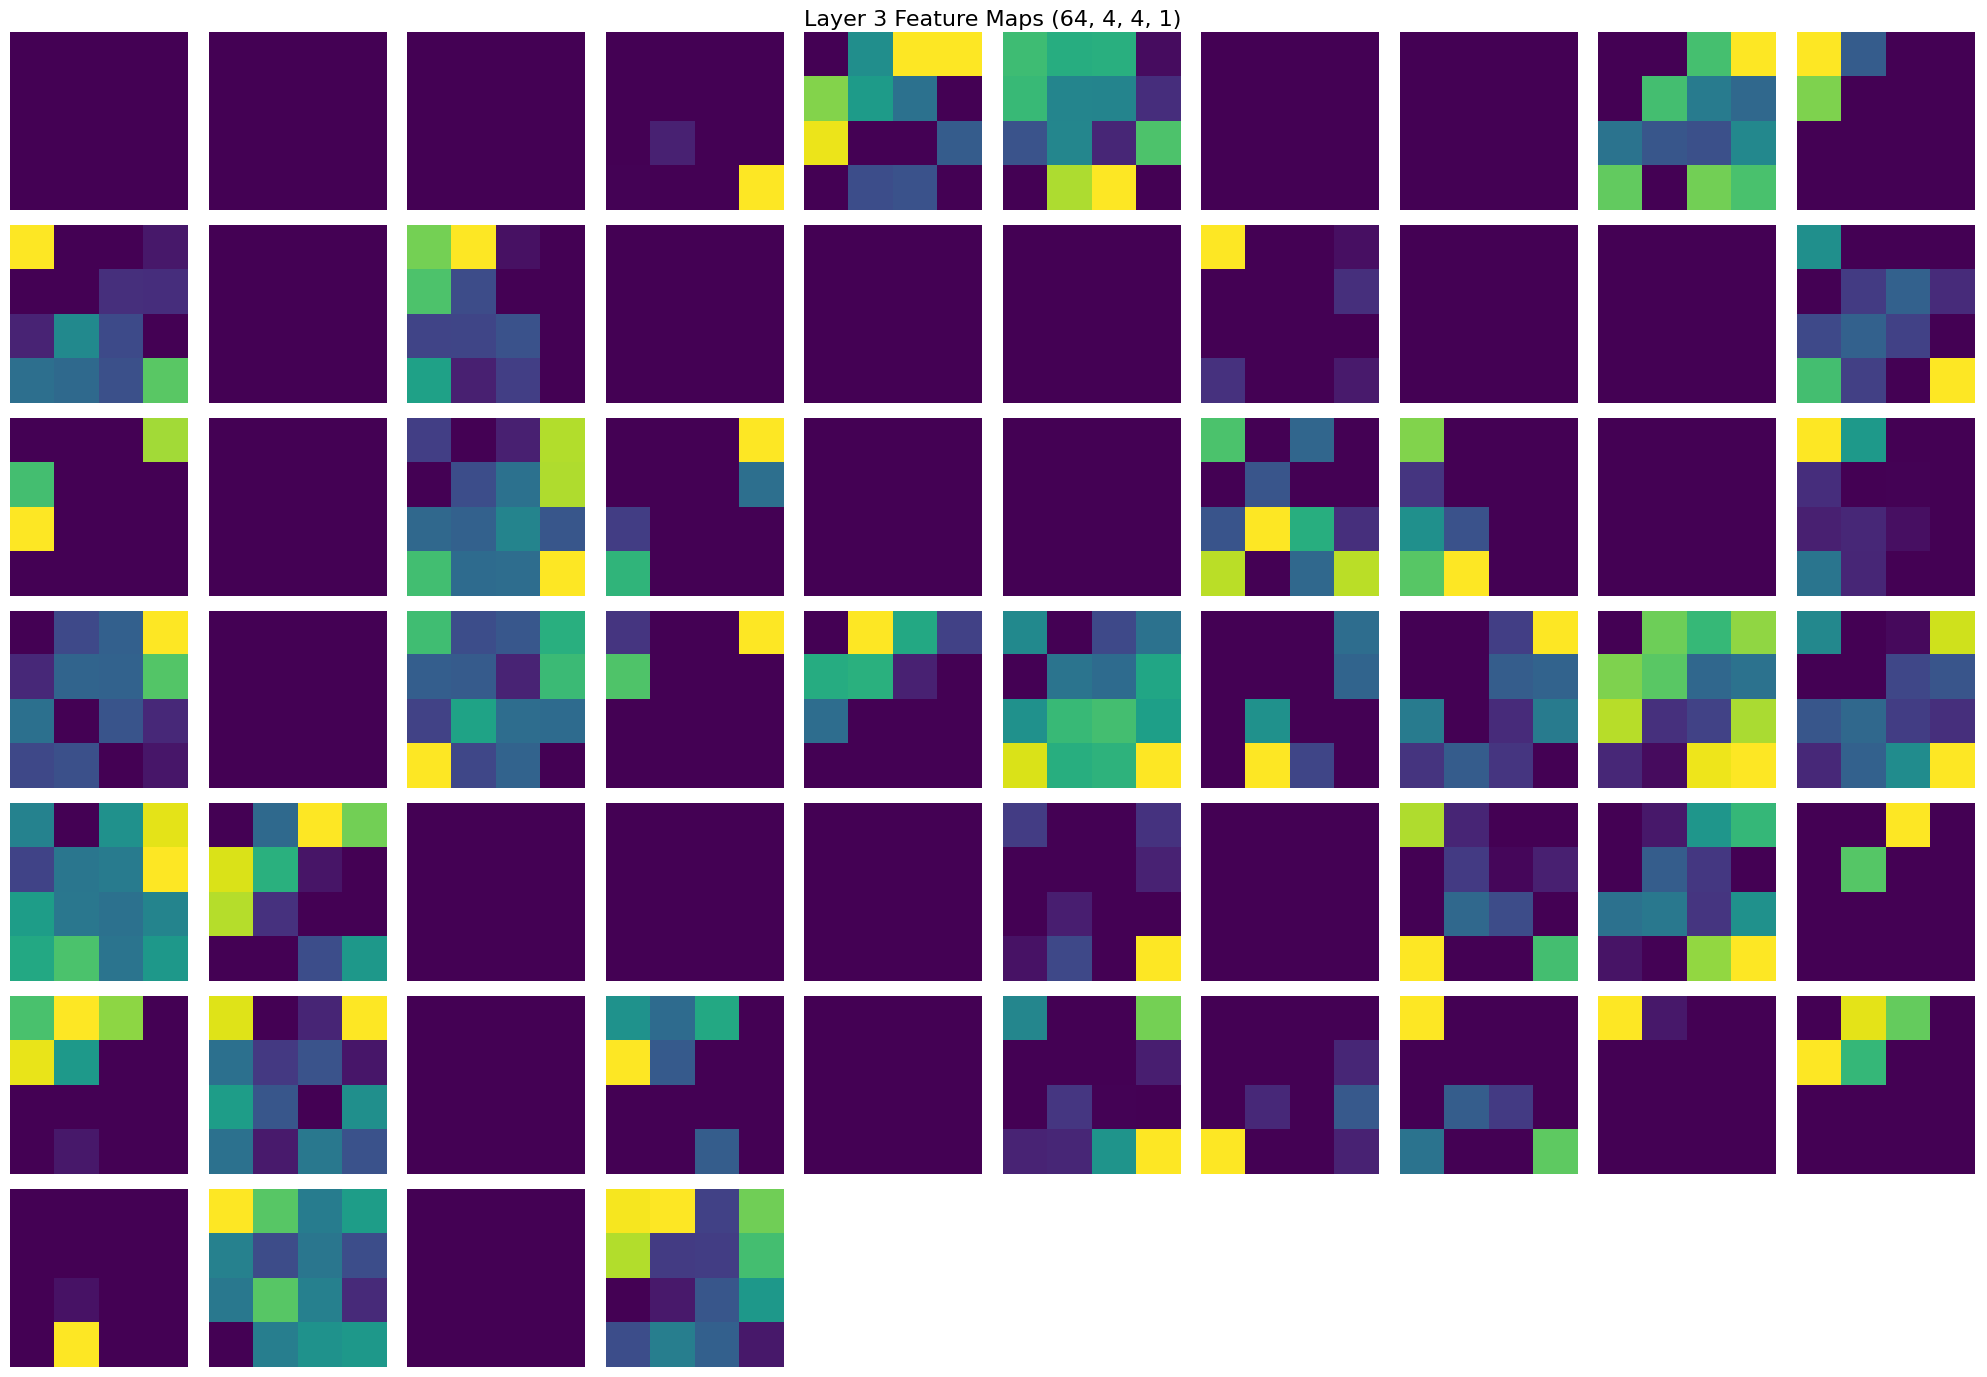

In [ ]:
# plot feature maps

# load trained model
d3_net = FlexiCNN(**model_d3)
d3_net.load_state_dict(fruitCNN_d3_trained)

# get feature maps for an image sample and plot it
augm_image = image_transform(data_tensor[np.random.randint(0, len(data_tensor))])
feature_maps = get_feature_maps(d3_net, augm_image)
plot_feature_maps(feature_maps)

##### -- 6.2.3 Testing on 4 CONV layers architecture

In [ ]:
# data split
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.3)
# data augmentation
train_data = customDataset(train_data, train_labels, transform=image_transform)
test_data  = customDataset(test_data, test_labels, transform=None)
# load data for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_d4_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(12, 7, 2, 1), (24, 5, 1, 1), (48, 3, 1, 1), (96, 3, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_d4 = FlexiCNN(**model_d4_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_d4, train_loader, lossfun, input_size=(3, 100, 100))

Conv 1 output: torch.Size([128, 12, 24, 24])
Conv 2 output: torch.Size([128, 24, 11, 11])
Conv 3 output: torch.Size([128, 48, 5, 5])
Conv 4 output: torch.Size([128, 96, 2, 2])
Flattened output: torch.Size([128, 384])
Final output: torch.Size([128, 33])

Model output shape: torch.Size([128, 33])
Target shape: torch.Size([128])

Loss: 3.497201442718506

Model Summary:
Conv 1 output: torch.Size([2, 12, 24, 24])
Conv 2 output: torch.Size([2, 24, 11, 11])
Conv 3 output: torch.Size([2, 48, 5, 5])
Conv 4 output: torch.Size([2, 96, 2, 2])
Flattened output: torch.Size([2, 384])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 48, 48]           1,776
         Dropout2d-2           [-1, 12, 24, 24]               0
            Conv2d-3           [-1, 24, 22, 22]           7,224
         Dropout2d-4           [-1, 24, 11, 11]               0
     

Early stopping triggered at 58 epoches
Execution time: 467.6434 seconds



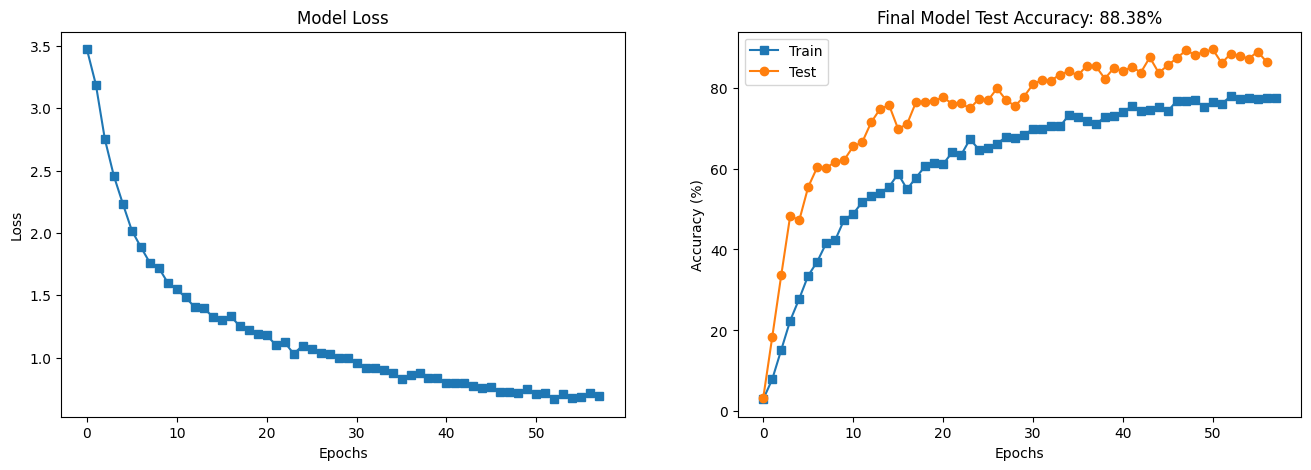

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_d4 = {**model_d4_info, "info": False}

# create the model
fruitCNN_d4 = FlexiCNN(**model_d4)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_d4.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model

start_time = time.time()  # Record the start time

net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_d4,
    train_loader,
    test_loader,
    **training_config)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time:.4f} seconds\n")

# Save the trianed net
fruitCNN_d4_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

In [ ]:
# plot feature maps

# load trained model
d4_net = FlexiCNN(**model_d4)
d4_net.load_state_dict(fruitCNN_d4_trained)

# get feature maps for an image sample and plot it
augm_image = image_transform(data_tensor[np.random.randint(0, len(data_tensor))])
feature_maps = get_feature_maps(d4_net, augm_image)
plot_feature_maps(feature_maps)

##### -- 6.2.4 Testing on 5 CONV layers architecture

In [ ]:
# data split
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.3)
# data augmentation
train_data = customDataset(train_data, train_labels, transform=image_transform)
test_data  = customDataset(test_data, test_labels, transform=None)
# load data for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_d5_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(12, 5, 1, 1), (24, 5, 1, 1), (48, 3, 1, 1), (96, 3, 1, 1), (128, 3, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_d5 = FlexiCNN(**model_d5_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_d5, train_loader, lossfun, input_size=(3, 100, 100))

Conv 1 output: torch.Size([128, 12, 49, 49])
Conv 2 output: torch.Size([128, 24, 23, 23])
Conv 3 output: torch.Size([128, 48, 11, 11])
Conv 4 output: torch.Size([128, 96, 5, 5])
Conv 5 output: torch.Size([128, 128, 2, 2])
Flattened output: torch.Size([128, 512])
Final output: torch.Size([128, 33])

Model output shape: torch.Size([128, 33])
Target shape: torch.Size([128])

Loss: 3.498037338256836

Model Summary:
Conv 1 output: torch.Size([2, 12, 49, 49])
Conv 2 output: torch.Size([2, 24, 23, 23])
Conv 3 output: torch.Size([2, 48, 11, 11])
Conv 4 output: torch.Size([2, 96, 5, 5])
Conv 5 output: torch.Size([2, 128, 2, 2])
Flattened output: torch.Size([2, 512])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 98, 98]             912
         Dropout2d-2           [-1, 12, 49, 49]               0
            Conv2d-3           [-1, 24, 47,

Early stopping triggered at 58 epoches
Execution time: 583.9382 seconds



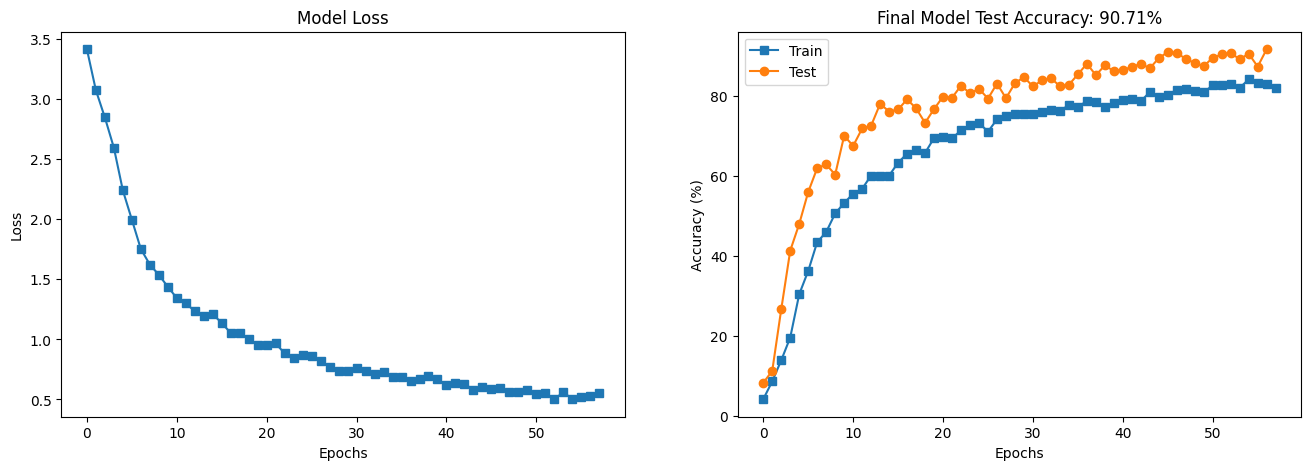

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_d5 = {**model_d5_info, "info": False}

# create the model
fruitCNN_d5 = FlexiCNN(**model_d5)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_d5.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model

start_time = time.time()  # Record the start time

net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_d5,
    train_loader,
    test_loader,
    **training_config)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time:.4f} seconds\n")

# Save the trianed net
fruitCNN_d5_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

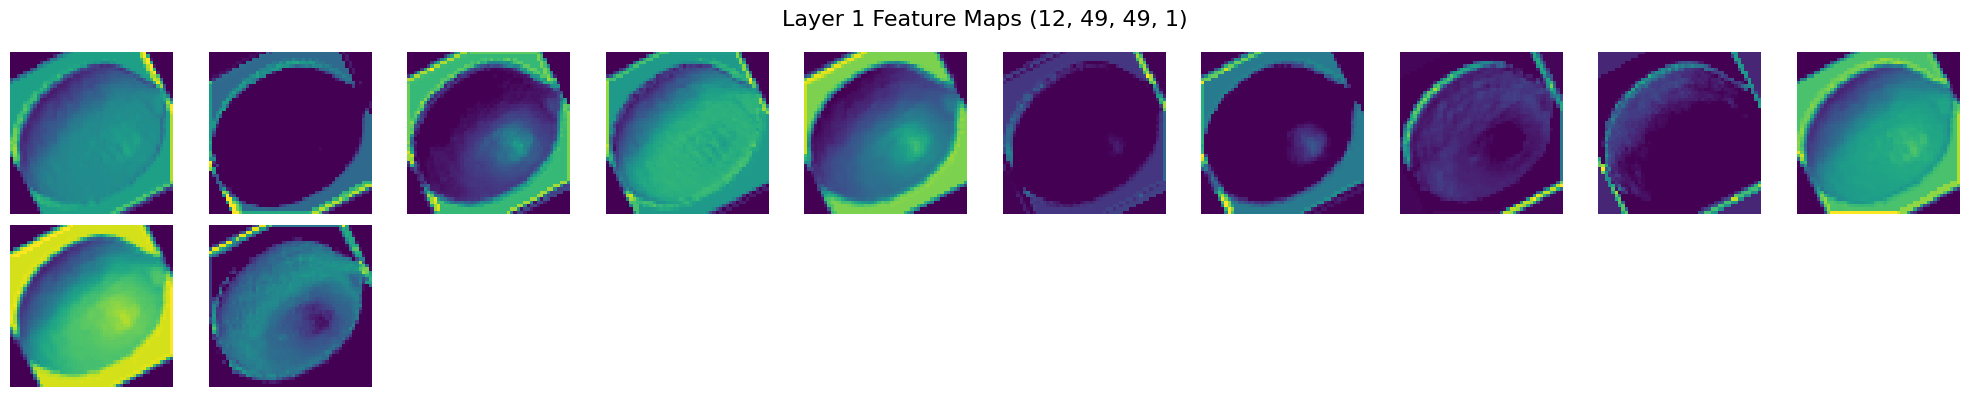

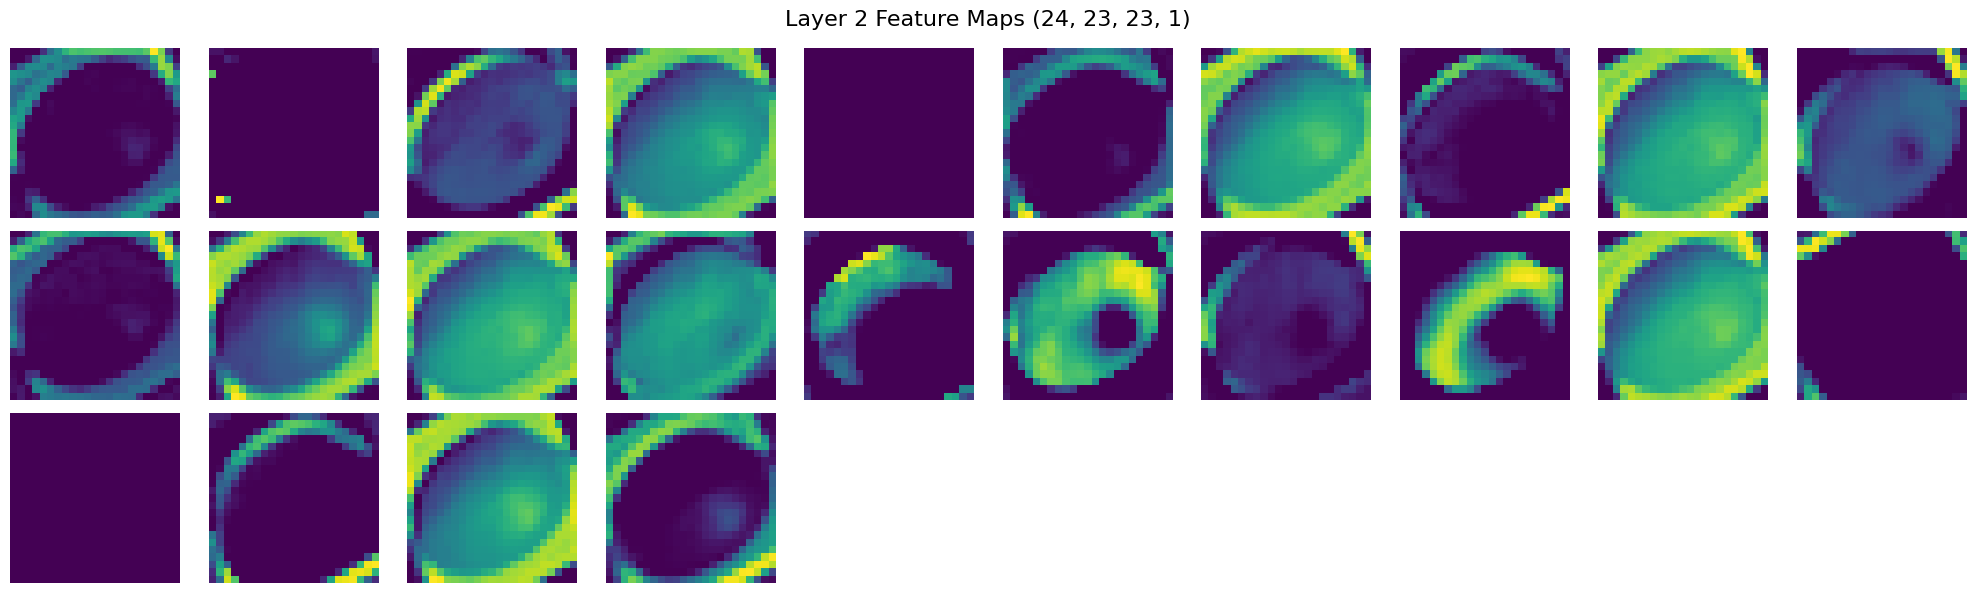

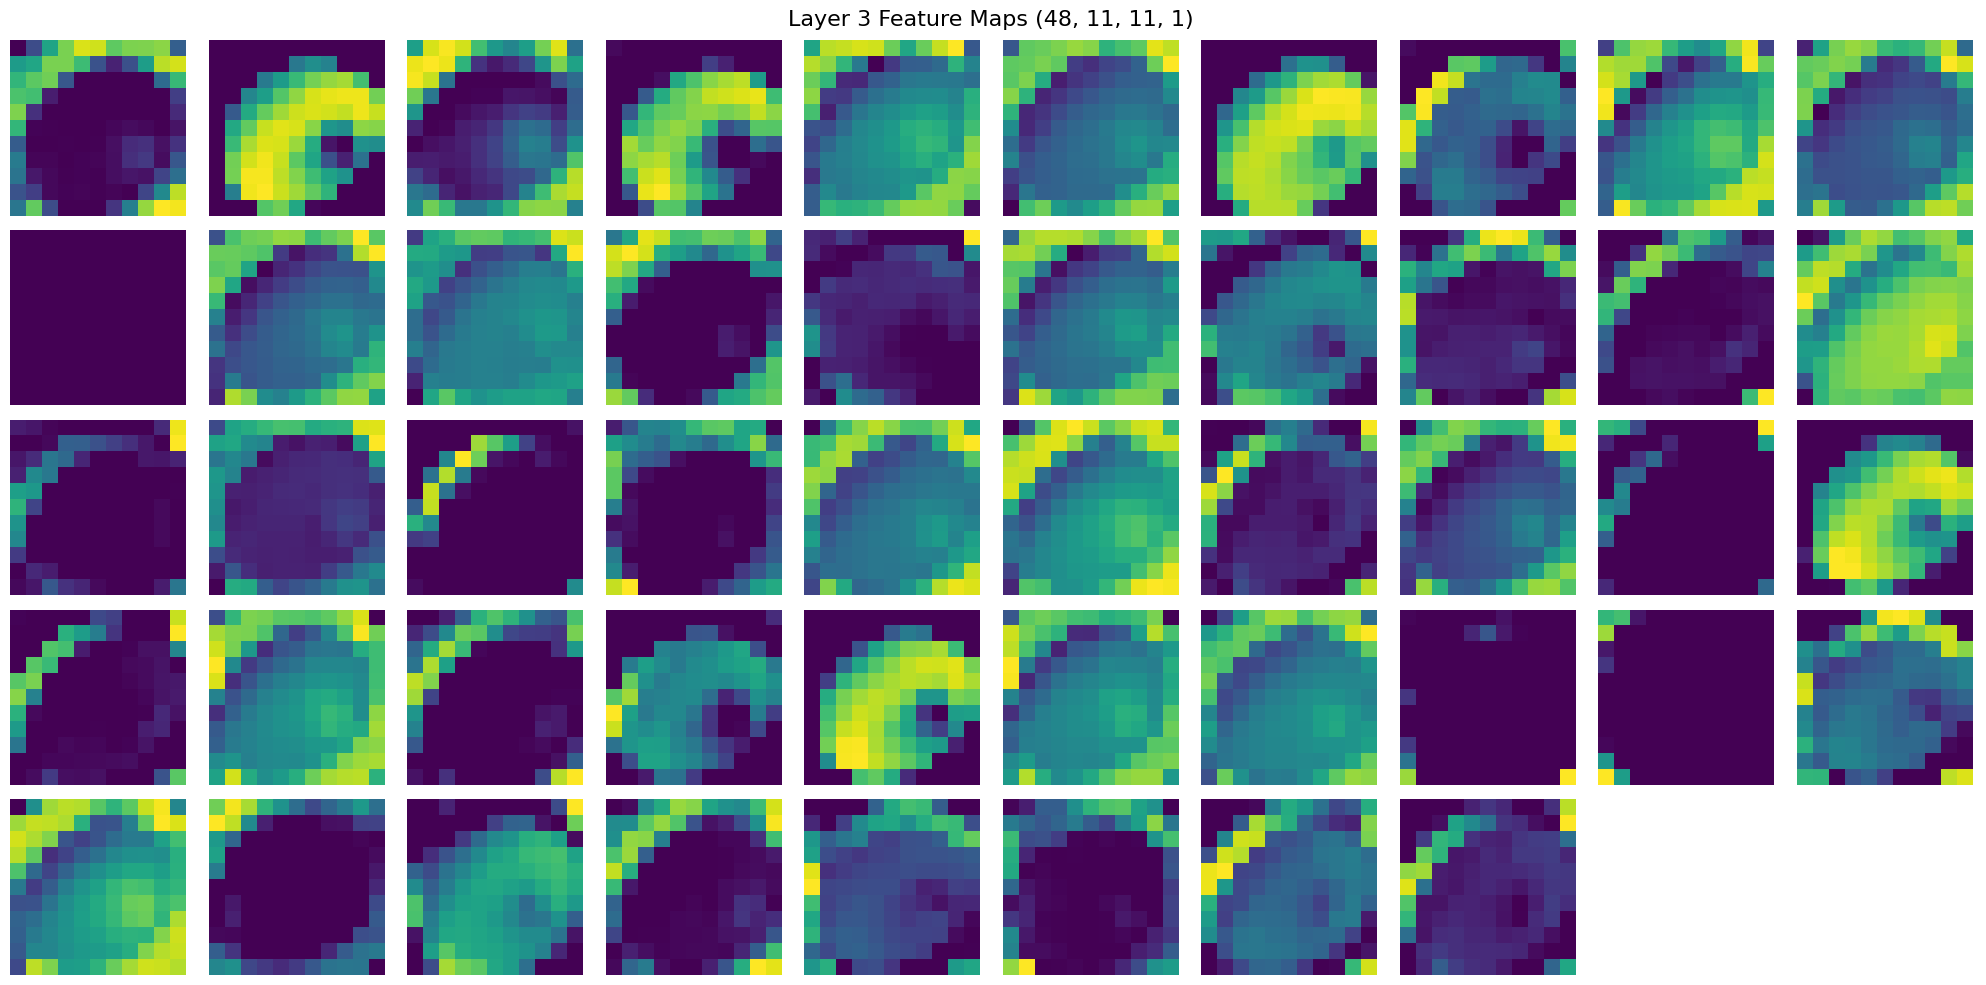

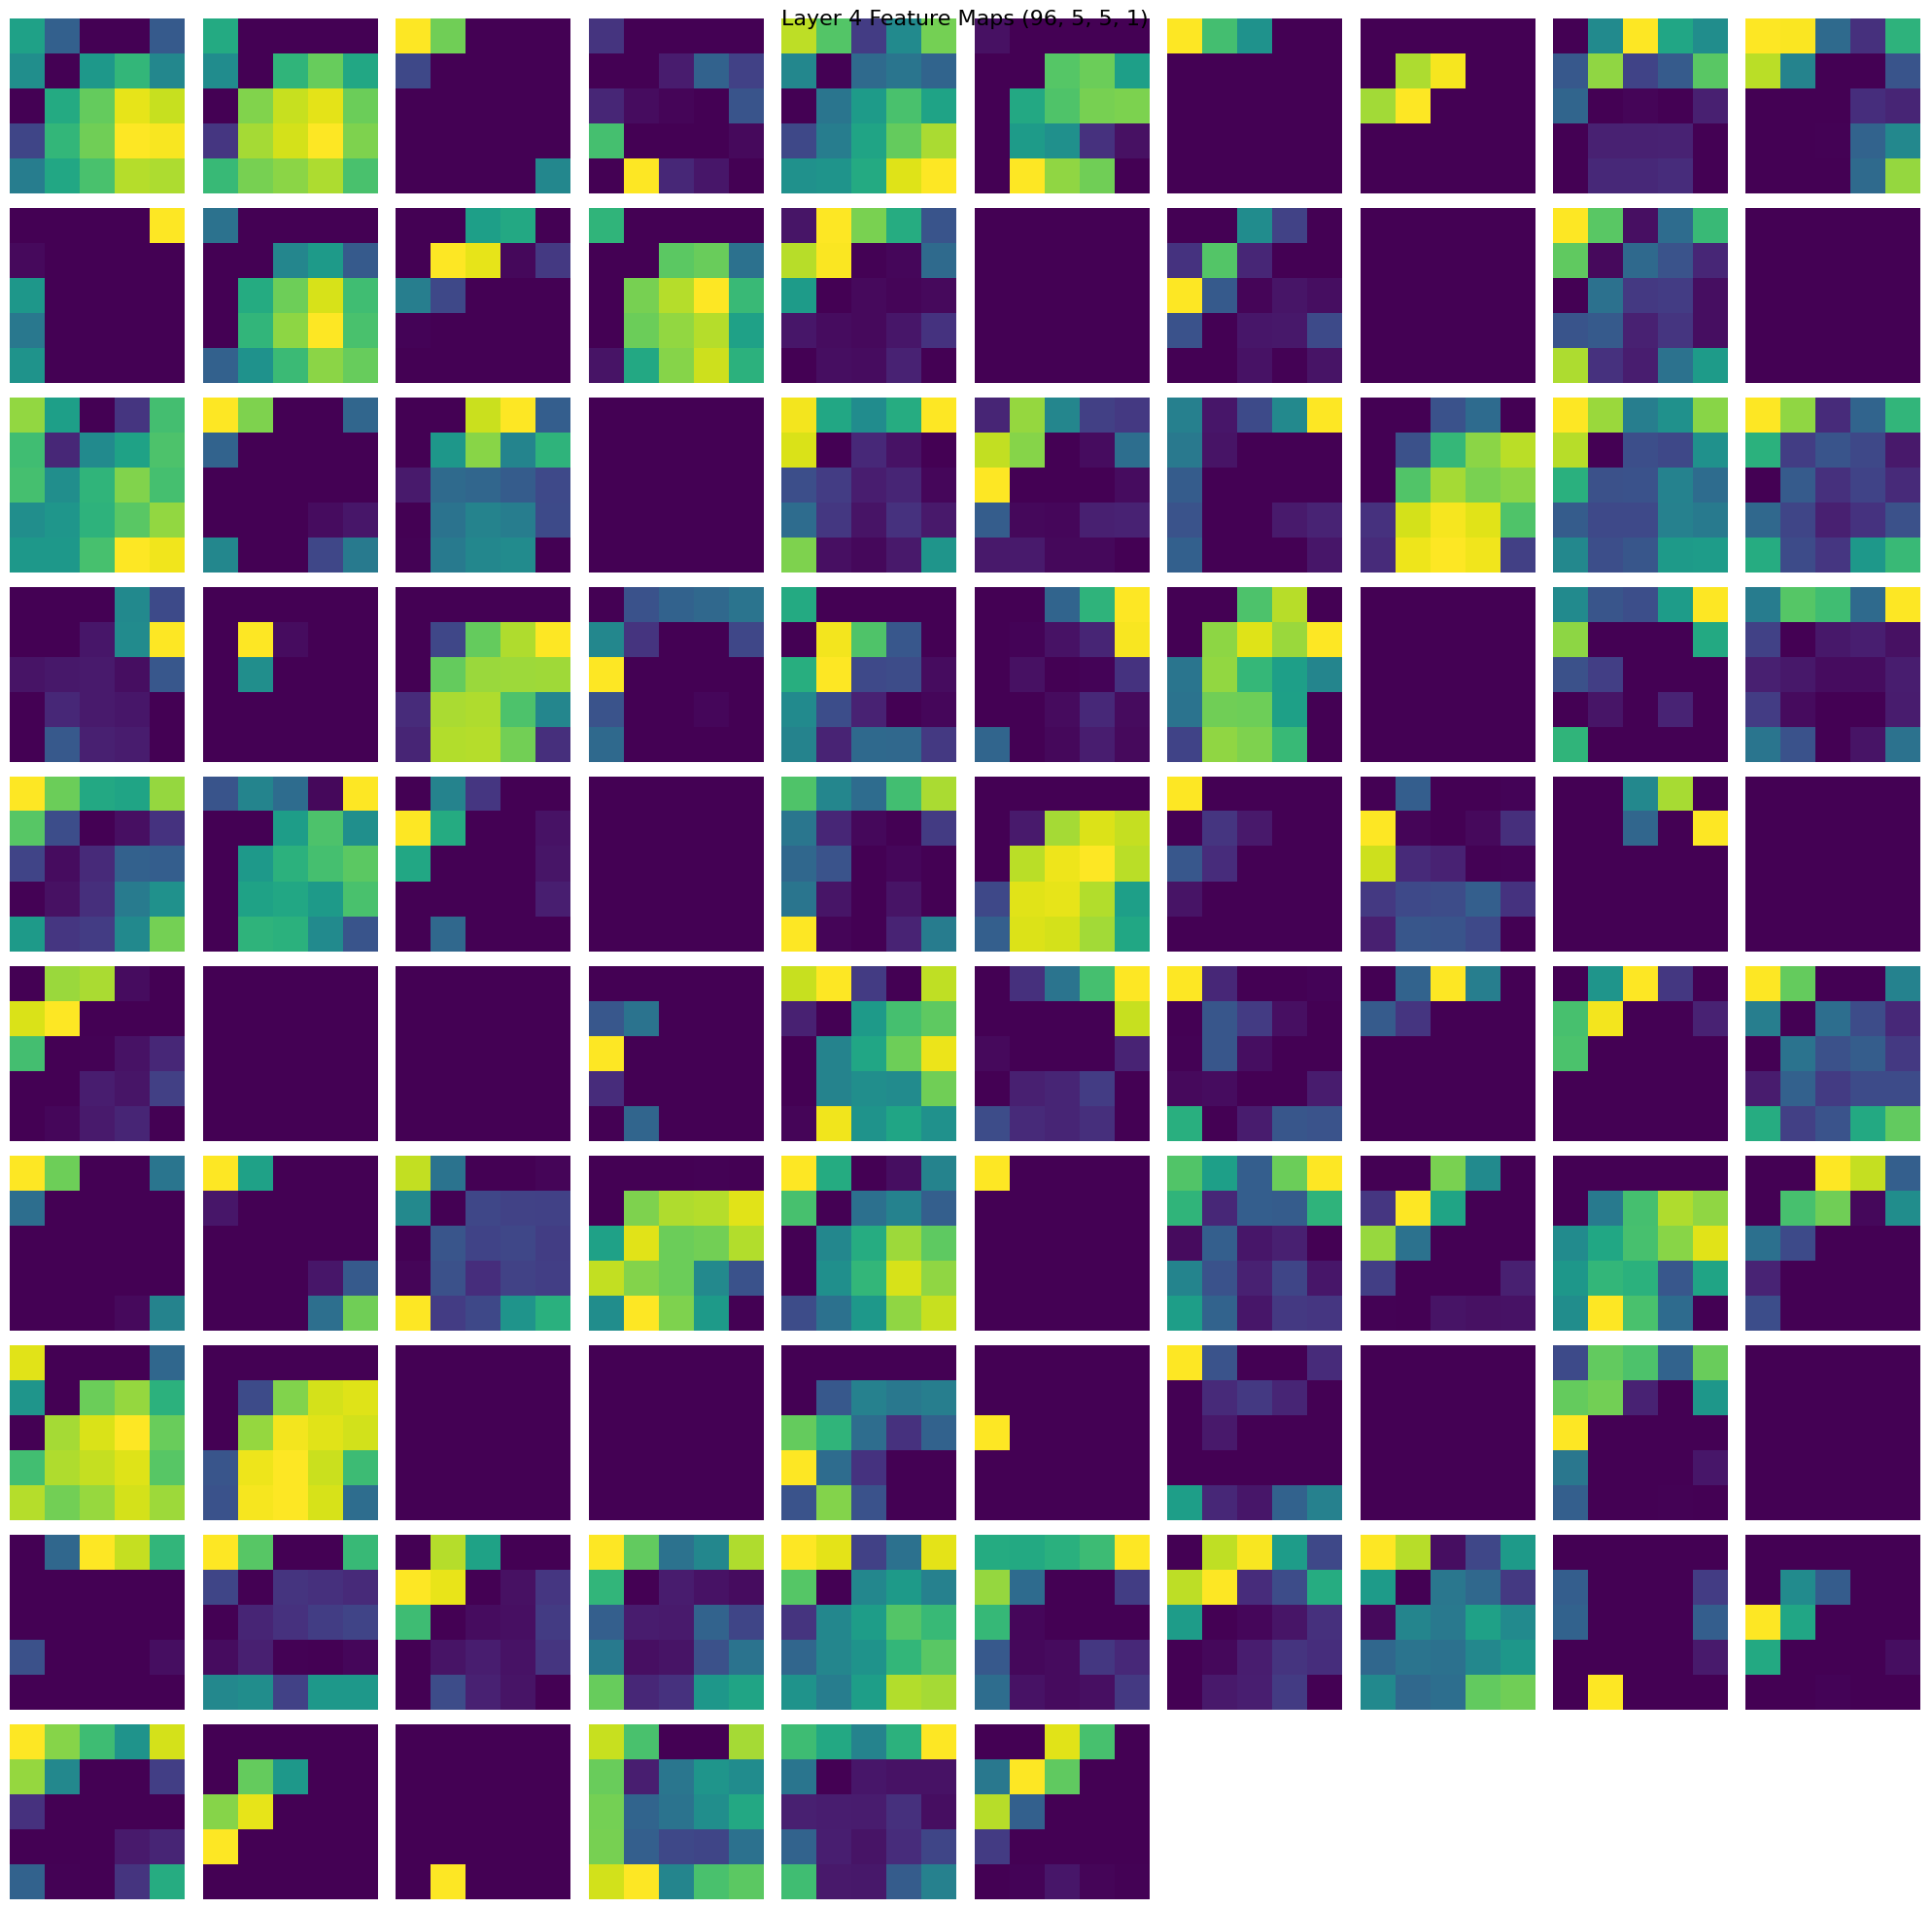

In [ ]:
# plot feature maps

# load trained model
d5_net = FlexiCNN(**model_d5)
d5_net.load_state_dict(fruitCNN_d5_trained)

# get feature maps for an image sample and plot it
augm_image = image_transform(data_tensor[np.random.randint(0, len(data_tensor))])
feature_maps = get_feature_maps(d5_net, augm_image)
plot_feature_maps(feature_maps)

#### - 6.3 Feature analysis - testing on 'Color' feature
--- change image to 'grayscale' to remove the impact of 'color' feature  
--- and testing on the model performance

In [ ]:
# Change the images to 'grayscale' to test 'Color' feature

# Define the grayscale transformation
gray_train = v2.Compose([
    v2.Grayscale(num_output_channels=1),  # Convert image to grayscale
    v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
])

gray_test = v2.Compose([
    v2.Grayscale(num_output_channels=1),  # Convert image to grayscale
    # v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    # v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    # v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
])

# select random images
gray_samples = 8
index_gray = np.random.choice(len(data_tensor), gray_samples, replace=False)
image_gray = data_tensor[index_gray]
label_gray = labels_tensor[index_gray]

# Create augmented images dataset
image_gray_augm = customDataset(image_gray, label_gray, transform=gray_train)
# Plot the images
plot_augmented_images(image_gray, image_gray_augm, gray_samples)

In [ ]:
# split data into train and test
train_data, test_data, train_labels,test_labels = train_test_split(data_tensor, labels_tensor, test_size=.2)
# data augmentation (grayscale)
train_data = customDataset(train_data, train_labels, transform=gray_train)
test_data  = customDataset(test_data, test_labels, transform=gray_test)
# send to DataLoader for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_gray_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(16, 7, 2, 1), (32, 5, 1, 1), (64, 5, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (1, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_gray = FlexiCNN(**model_gray_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_gray, train_loader, lossfun, input_size=(1, 100, 100))

Conv 1 output: torch.Size([128, 16, 24, 24])
Conv 2 output: torch.Size([128, 32, 11, 11])
Conv 3 output: torch.Size([128, 64, 4, 4])
Flattened output: torch.Size([128, 1024])
Final output: torch.Size([128, 33])

Model output shape: torch.Size([128, 33])
Target shape: torch.Size([128])

Loss: 3.501024007797241

Model Summary:
Conv 1 output: torch.Size([2, 16, 24, 24])
Conv 2 output: torch.Size([2, 32, 11, 11])
Conv 3 output: torch.Size([2, 64, 4, 4])
Flattened output: torch.Size([2, 1024])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             800
         Dropout2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 22, 22]          12,832
         Dropout2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 9, 9]          51,264
         Dropout2d-6   

Early stopping triggered at 75 epoches
Execution time: 305.1648 seconds



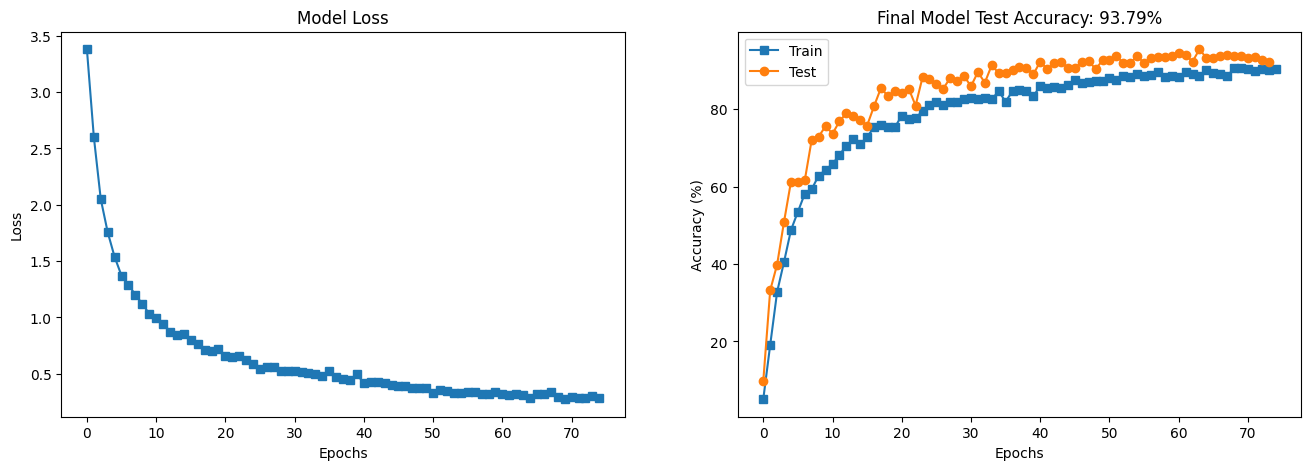

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_gray = {**model_gray_info, "info": False}

# create the model
fruitCNN_gray = FlexiCNN(**model_gray)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_gray.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model
start_time = time.time()  # Record the start time

net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_gray,
    train_loader,
    test_loader,
    **training_config)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time:.4f} seconds\n")

# Save the trianed net
fruitCNN_gray_tratned= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

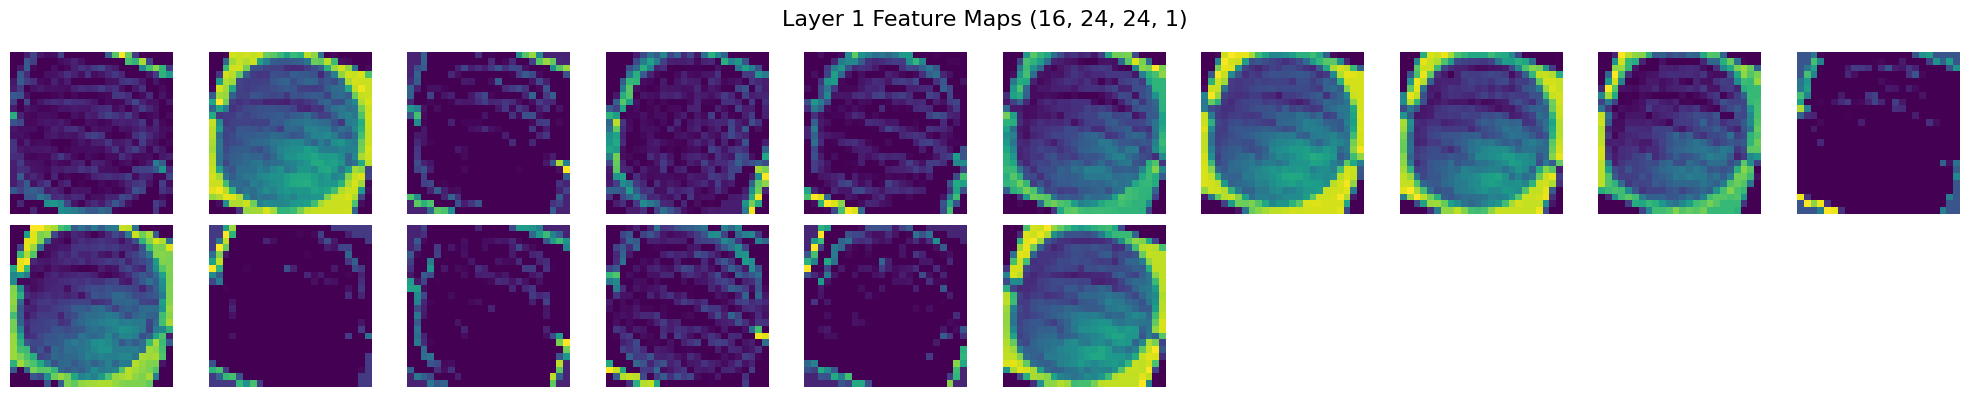

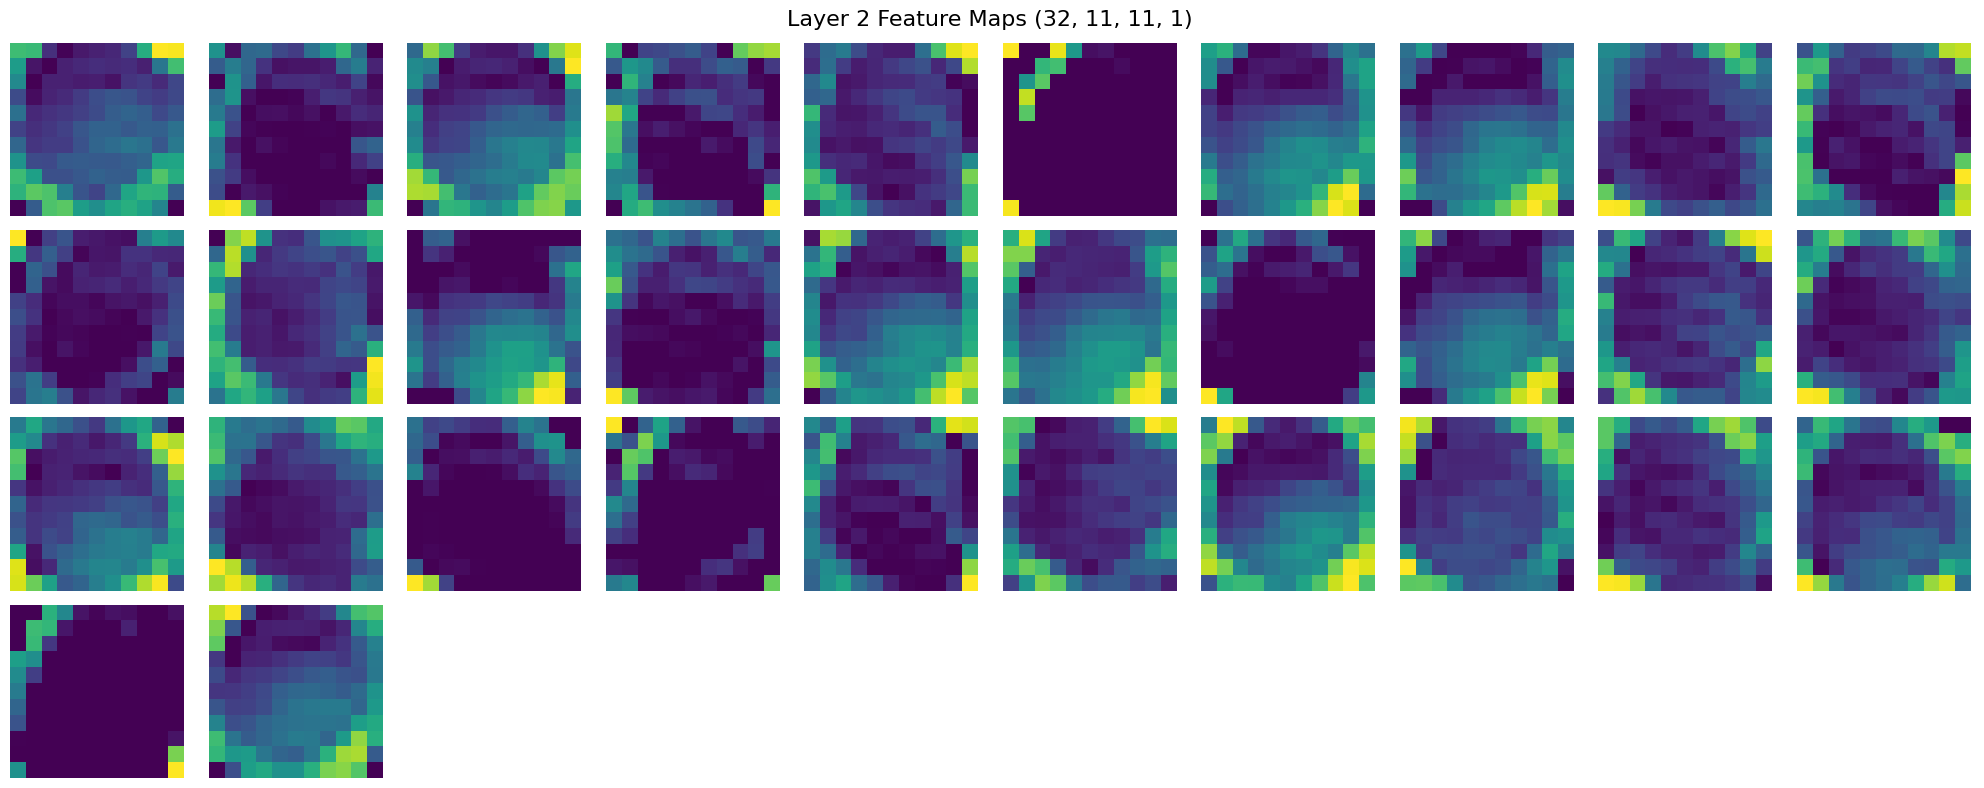

In [ ]:
# plot feature maps

# load trained model
gray_net = FlexiCNN(**model_gray)
gray_net.load_state_dict(fruitCNN_gray_tratned)

# get feature maps for an image sample and plot it
gray_image = gray_train(data_tensor[np.random.randint(0, len(data_tensor))])
feature_maps = get_feature_maps(gray_net, gray_image)
plot_feature_maps(feature_maps)

#### - 6.4 Feature analysis - testing on 'Shape' feature
--- manually stretch to similar shape  
--- adding profile contours

##### -- 6.4.1 Option 1 - manually pick similar shape and stretch to similar shape

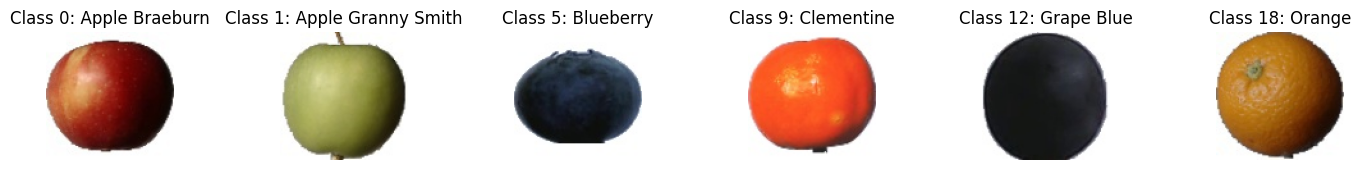

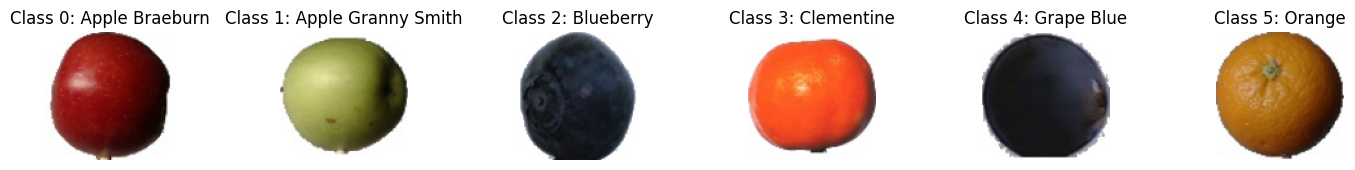

In [ ]:
# pick fruit and vegetable with similar shape and redo to label mapping

# pick classes by label index
index_shape = [0, 1, 5, 9, 12, 18]

# pick samples by selected label index
picked_data, picked_labels, picked_mapping = pick_samples(tot_train_data, tot_train_labels, label_mapping, 200, index_shape)
# plot an instance of the picked images
plot_image_map(picked_data, picked_labels, picked_mapping, num_columns=6)


# Create a new map with the same keys but with values as sequential integers
new_mapping = {key: i for i, key in enumerate(picked_mapping.keys())}
# remaping the label to sequence number as 0, 1, 2 ...
new_labels = np.searchsorted(index_shape, picked_labels)
# plot an instance of the picked images
plot_image_map(picked_data, new_labels, new_mapping, num_columns=6)

In [ ]:
# normalization to [0 1]
shape_dataNorm = picked_data / np.max(picked_data)
# move axis 'channel' axis to dimension [0] (CHW means channel Height Width)
shape_dataCHW = np.transpose(shape_dataNorm, (0, 3, 1, 2))

# convert to torch tensor and move 'channel' axis
data_tensor_shape = torch.tensor(shape_dataCHW).float()
labels_tensor_shape = torch.tensor(new_labels).long()

print(data_tensor_shape.shape)
print(labels_tensor_shape.shape)

torch.Size([1200, 3, 100, 100])
torch.Size([1200])


In [ ]:
# data augmentation
shape_train = v2.Compose([
    # transforms.RandomResizedCrop(224),  # Randomly crops and resizes the image mainly for pretrained model
    v2.Grayscale(num_output_channels=1),  # Convert image to grayscale
    # v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    # v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    # transforms.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(0, 10, 0, 10)),  # Random affine transformation, translate = %shifted
    v2.RandomAffine(degrees=90, shear=(0, 10, 0, 10)),
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
    ])

shape_test = v2.Compose([
    # transforms.RandomResizedCrop(224),  # Randomly crops and resizes the image mainly for pretrained model
    v2.Grayscale(num_output_channels=1),  # Convert image to grayscale
    # v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    # v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    # transforms.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(0, 10, 0, 10)),  # Random affine transformation, translate = %shifted
    # v2.RandomAffine(degrees=90, shear=(0, 10, 0, 10)),
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
    ])

# select random images
num_samples = 8
index_rand = np.random.choice(len(data_tensor_shape), num_samples, replace=False)
image_rand = data_tensor_shape[index_rand]
label_rand = labels_tensor_shape[index_rand]

# augmented images
image_augm = customDataset(image_rand, label_rand, transform=shape_train)
# plot the images
plot_augmented_images(image_rand, image_augm, num_samples)

In [ ]:
# split data into train and test
train_data, test_data, train_labels,test_labels = train_test_split(data_tensor_shape, labels_tensor_shape, test_size=.2)
# data augmentation (grayscale)
train_data = customDataset(train_data, train_labels, transform=shape_train)
test_data  = customDataset(test_data, test_labels, transform=shape_test)
# send to DataLoader for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_s1_info = {
    "n_classes": 6,  # number of classes
    "conv_config": [(16, 7, 2, 1), (32, 5, 1, 1), (64, 5, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (1, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_s1 = FlexiCNN(**model_s1_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_s1, train_loader, lossfun, input_size=(1, 100, 100))

Conv 1 output: torch.Size([128, 16, 24, 24])
Conv 2 output: torch.Size([128, 32, 11, 11])
Conv 3 output: torch.Size([128, 64, 4, 4])
Flattened output: torch.Size([128, 1024])
Final output: torch.Size([128, 6])

Model output shape: torch.Size([128, 6])
Target shape: torch.Size([128])

Loss: 1.784212589263916

Model Summary:
Conv 1 output: torch.Size([2, 16, 24, 24])
Conv 2 output: torch.Size([2, 32, 11, 11])
Conv 3 output: torch.Size([2, 64, 4, 4])
Flattened output: torch.Size([2, 1024])
Final output: torch.Size([2, 6])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             800
         Dropout2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 22, 22]          12,832
         Dropout2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 9, 9]          51,264
         Dropout2d-6      

Early stopping triggered at 26 epoches
Execution time: 35.1763 seconds



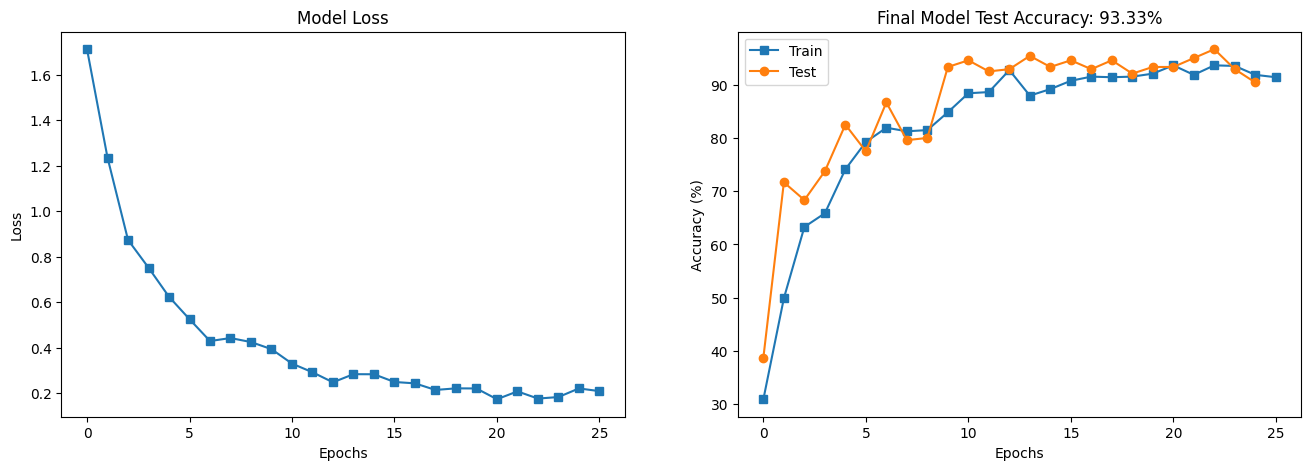

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_s1 = {**model_s1_info, "info": False}

# create the model
fruitCNN_s1 = FlexiCNN(**model_s1)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_s1.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model
start_time = time.time()  # Record the start time

net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_s1,
    train_loader,
    test_loader,
    **training_config)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time:.4f} seconds\n")

# Save the trianed net
fruitCNN_s1_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

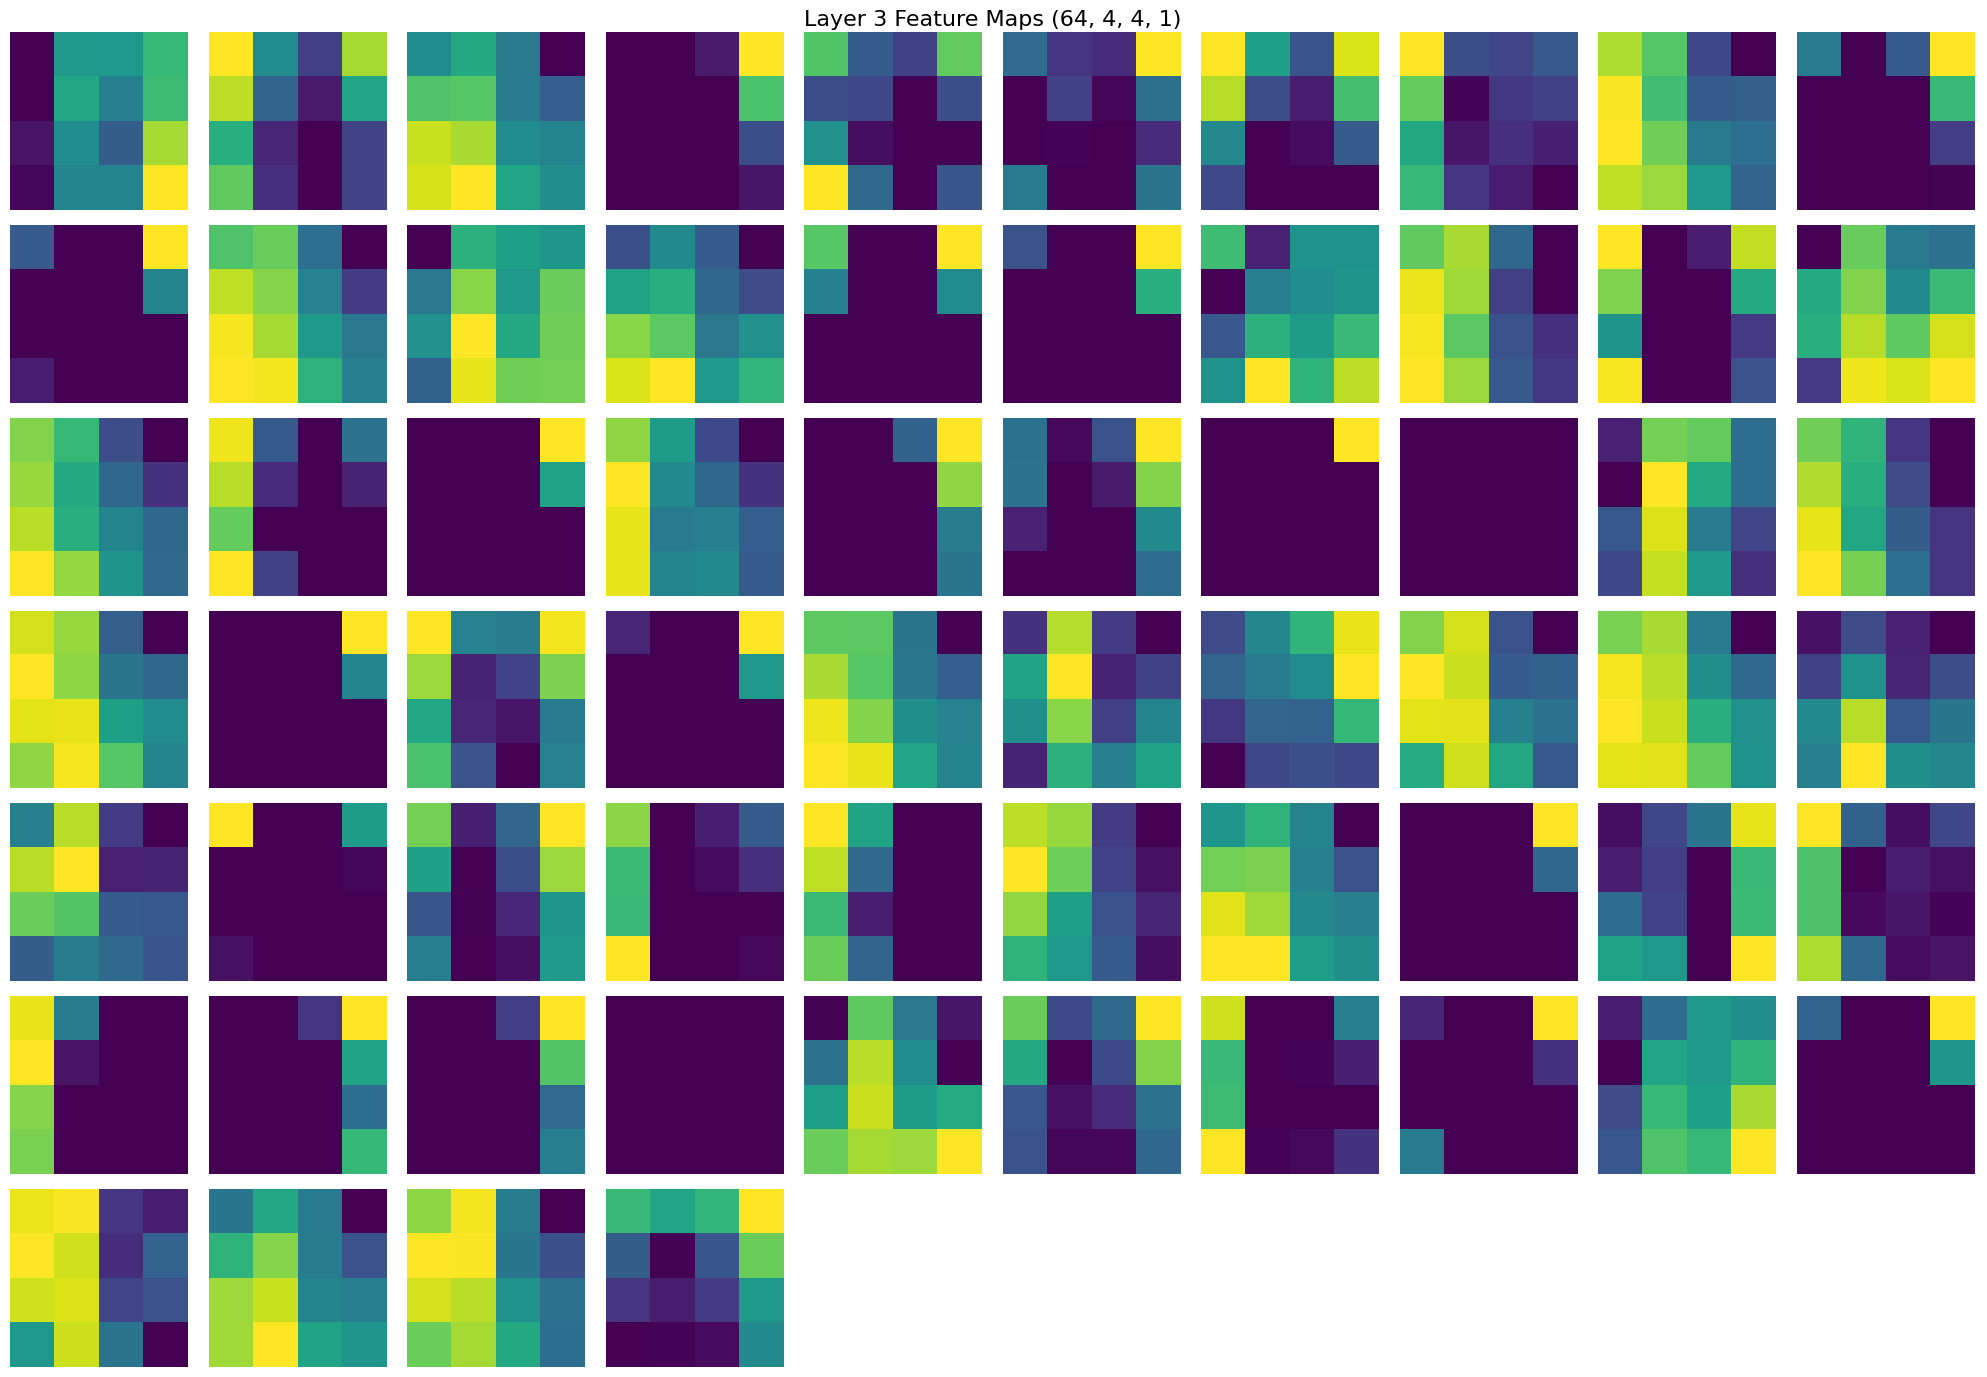

In [ ]:
# plot feature maps

# load trained model
s1_net = FlexiCNN(**model_s1)
s1_net.load_state_dict(fruitCNN_s1_trained)

# get feature maps for an image sample and plot it
augm_image = shape_train(data_tensor[np.random.randint(0, len(data_tensor))])
feature_maps = get_feature_maps(s1_net, augm_image)
plot_feature_maps(feature_maps)

##### -- 6.4.2 Option 2 - testing on 'Shape' feature by adding contours

In [ ]:
# create list for contours image
data_contours = torch.empty_like(data_tensor)

# add contours to image
for i in range(len(data_tensor)):
  data_contours[i] = image_contours_tensor(data_tensor[i])

# data_contours = data_contours.permute(0, 2, 3, 1)
print(data_contours.shape)

torch.Size([3300, 3, 100, 100])


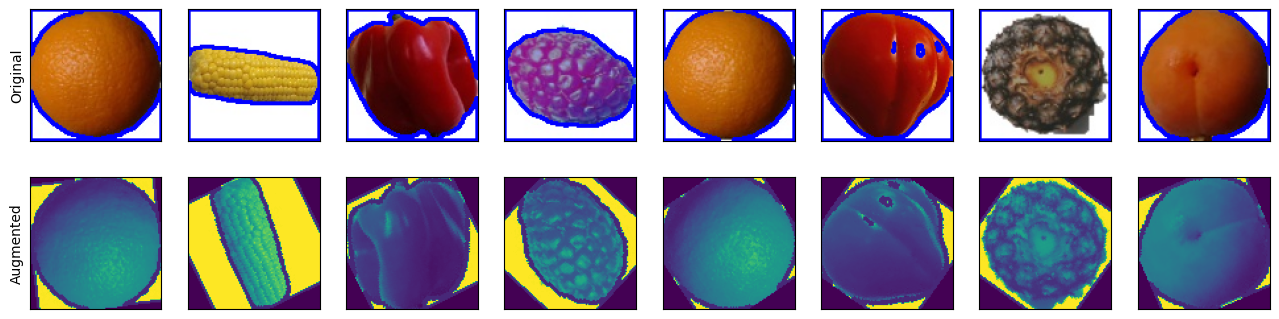

In [ ]:
# Change the images to 'grayscale'

# Define the grayscale transformation
contours_train = v2.Compose([
    v2.Grayscale(num_output_channels=1),  # Convert image to grayscale
    v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
])

contours_test = v2.Compose([
    v2.Grayscale(num_output_channels=1),  # Convert image to grayscale
    # v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    # v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    # v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
])

# select random images
contours_samples = 8
index_cont = np.random.choice(len(data_contours), contours_samples, replace=False)
image_cont = data_contours[index_cont]
label_cont = labels_tensor[index_cont]

# Create augmented images dataset
image_cont_augm = customDataset(image_cont, label_cont, transform=contours_train)
# Plot the images
plot_augmented_images(image_cont, image_cont_augm, contours_samples)

In [ ]:
# split data into train and test
train_data, test_data, train_labels,test_labels = train_test_split(data_contours, labels_tensor, test_size=.2)
# data augmentation (grayscale)
train_data = customDataset(train_data, train_labels, transform=contours_train)
test_data  = customDataset(test_data, test_labels, transform=contours_test)
# send to DataLoader for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_s2_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(16, 7, 2, 1), (32, 5, 1, 1), (64, 5, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (1, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_s2 = FlexiCNN(**model_s2_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_s2, train_loader, lossfun, input_size=(1, 100, 100))

Conv 1 output: torch.Size([128, 16, 24, 24])
Conv 2 output: torch.Size([128, 32, 11, 11])
Conv 3 output: torch.Size([128, 64, 4, 4])
Flattened output: torch.Size([128, 1024])
Final output: torch.Size([128, 33])

Model output shape: torch.Size([128, 33])
Target shape: torch.Size([128])

Loss: 3.4976677894592285

Model Summary:
Conv 1 output: torch.Size([2, 16, 24, 24])
Conv 2 output: torch.Size([2, 32, 11, 11])
Conv 3 output: torch.Size([2, 64, 4, 4])
Flattened output: torch.Size([2, 1024])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             800
         Dropout2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 22, 22]          12,832
         Dropout2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 9, 9]          51,264
         Dropout2d-6  

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_s2 = {**model_s2_info, "info": False}

# create the model
fruitCNN_s2 = FlexiCNN(**model_s2)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_s2.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model
start_time = time.time()  # Record the start time

net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_s2,
    train_loader,
    test_loader,
    **training_config)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

print(f"Execution time: {execution_time:.4f} seconds\n")

# Save the trianed net
fruitCNN_s2_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

Early stopping triggered at 76 epoches
Execution time: 295.9888 seconds



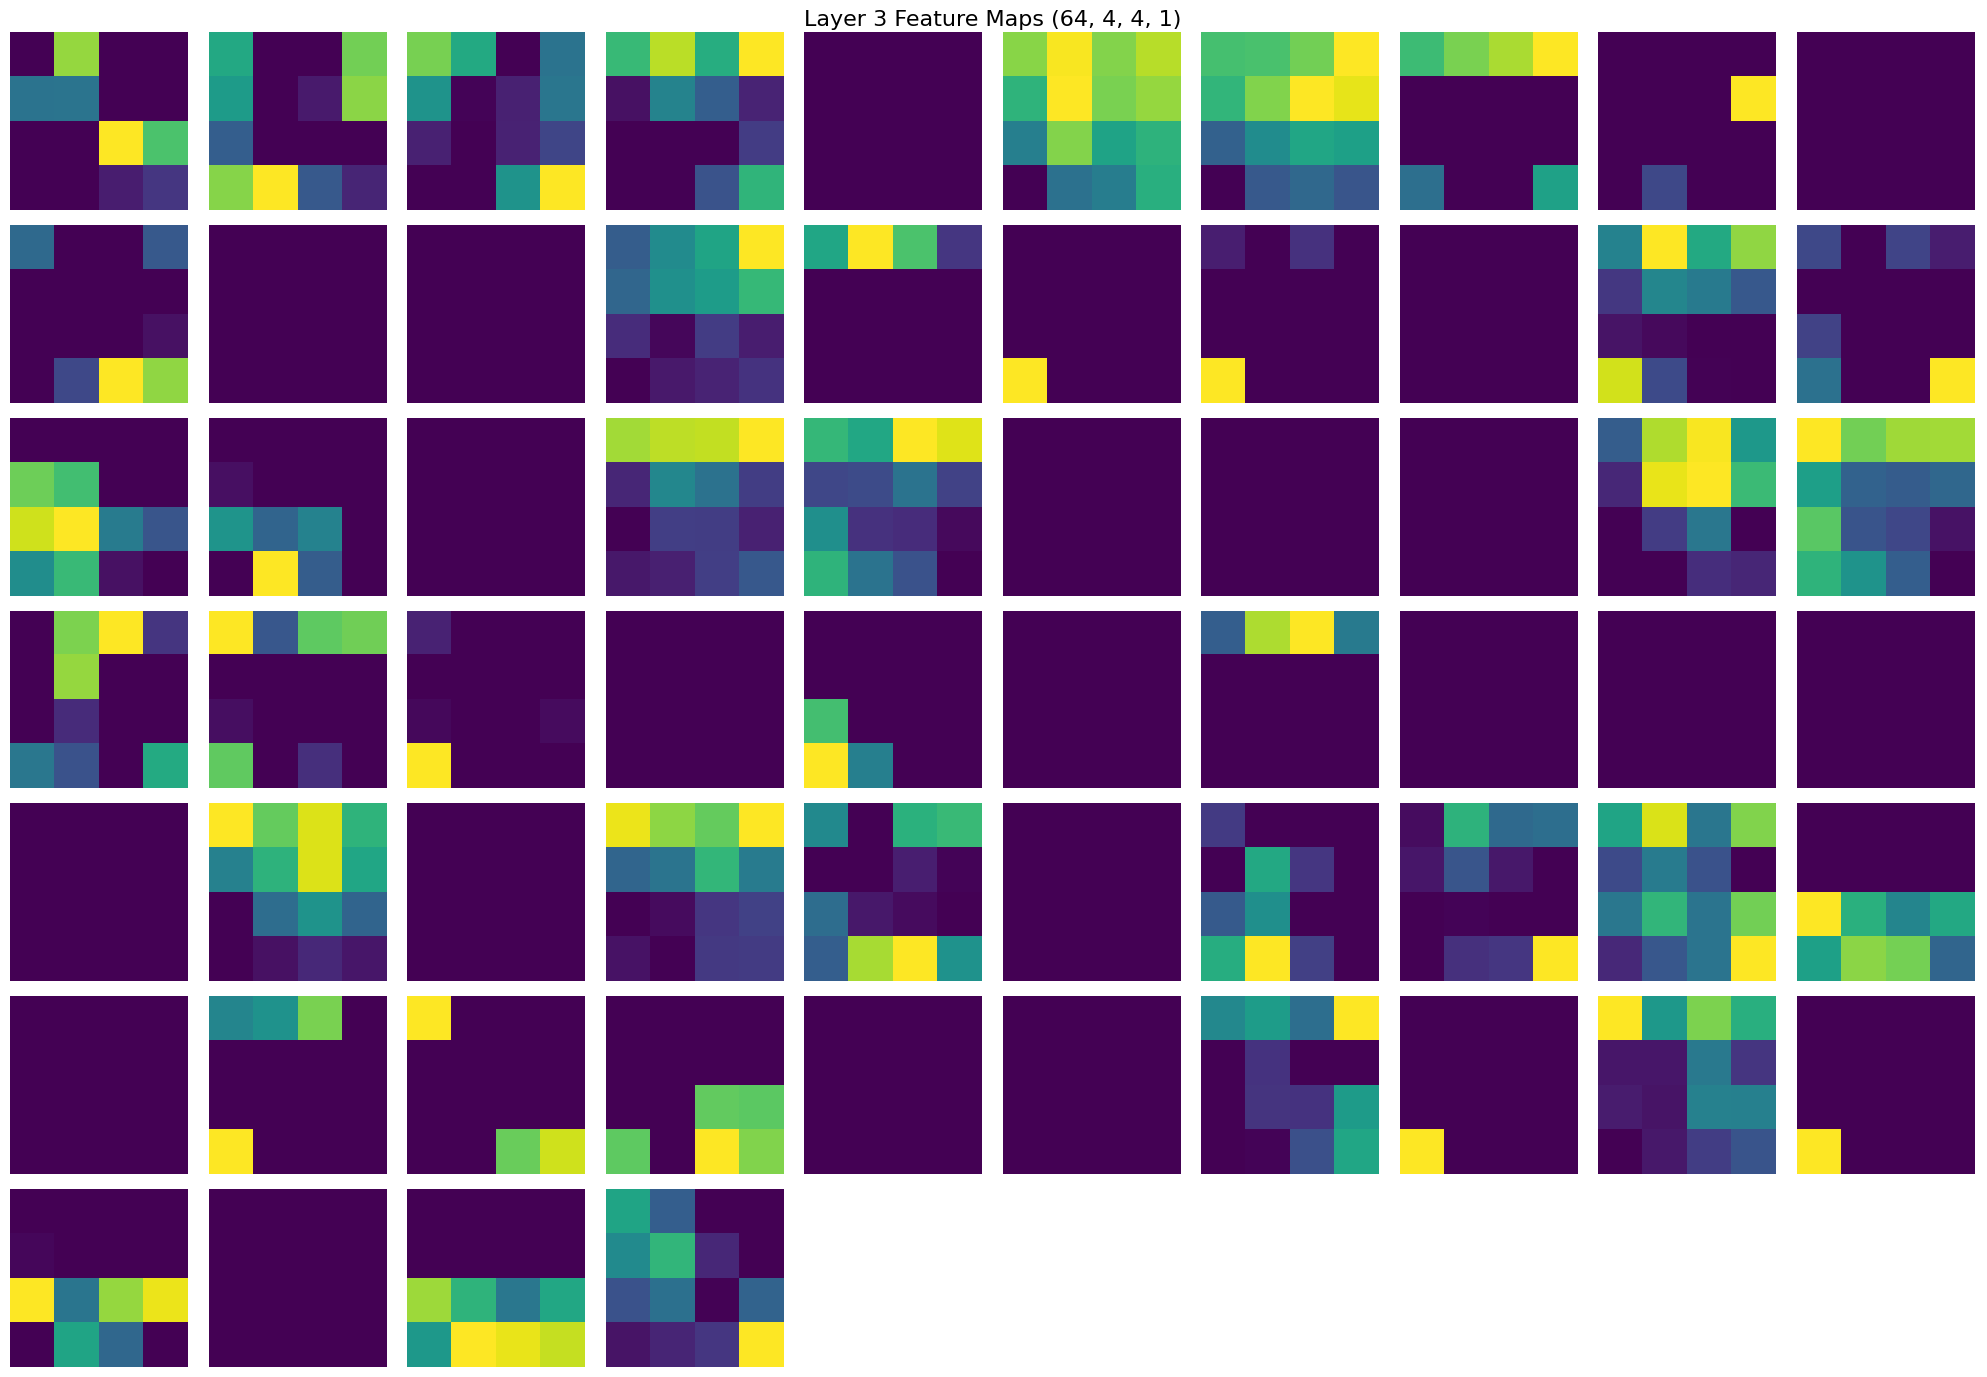

In [ ]:
# plot feature maps

# load trained model
s2_net = FlexiCNN(**model_s2)
s2_net.load_state_dict(fruitCNN_s2_trained)

# get feature maps for an image sample and plot it
augm_image = contours_test(data_contours[np.random.randint(0, len(data_contours))])
feature_maps = get_feature_maps(s2_net, augm_image)
plot_feature_maps(feature_maps)

#### - 6.5 Feature analysis - testing on 'Texture' feature
--- testing on image filled with uniform single color that eliminate the 'texture' feature

In [ ]:
# create list for color filled image
data_filled = np.empty_like(selected_data)

# filled uniform color to image
for i in range(len(selected_data)):
  data_filled[i] = fill_uniform_color(selected_data[i])

# normalization to [0 1]
selected_dataNorm = data_filled / np.max(data_filled)
# move axis 'channel' axis to dimension [0] (CHW means channel Height Width)
selected_dataCHW = np.transpose(selected_dataNorm, (0, 3, 1, 2))

# convert to torch tensor and move 'channel' axis
data_tensor_filled = torch.tensor(selected_dataCHW).float()
labels_tensor = torch.tensor(selected_labels).long()

print(data_tensor_filled.shape)
print(labels_tensor.shape)

torch.Size([3300, 3, 100, 100])
torch.Size([3300])


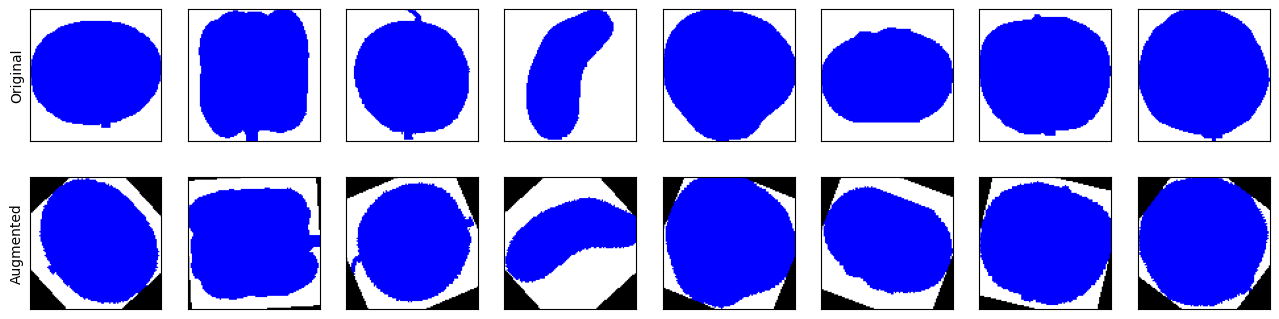

In [ ]:
# data augmentation
image_filled = v2.Compose([
    # v2.RandomResizedCrop(224),  # Randomly crops and resizes the image mainly for pretrained model
    v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
    ])

# select random images
num_samples = 8
index_rand = np.random.choice(len(data_tensor_filled), num_samples, replace=False)
image_rand = data_tensor_filled[index_rand]
label_rand = labels_tensor[index_rand]

# augmented images
image_augm = customDataset(image_rand, label_rand, transform=image_filled)
# plot the images
plot_augmented_images(image_rand, image_augm, num_samples)

In [ ]:
# split data into train and test
train_data, test_data, train_labels,test_labels = train_test_split(data_tensor_filled, labels_tensor, test_size=.2)
# data augmentation (grayscale)
train_data = customDataset(train_data, train_labels, transform=image_filled)
test_data  = customDataset(test_data, test_labels, transform=image_filled)
# send to DataLoader for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_fc_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(16, 7, 2, 1), (32, 5, 1, 1), (64, 5, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitCNN_fc = FlexiCNN(**model_fc_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitCNN_fc, train_loader, lossfun, input_size=(3, 100, 100))

Conv 1 output: torch.Size([128, 16, 24, 24])
Conv 2 output: torch.Size([128, 32, 11, 11])
Conv 3 output: torch.Size([128, 64, 4, 4])
Flattened output: torch.Size([128, 1024])
Final output: torch.Size([128, 33])

Model output shape: torch.Size([128, 33])
Target shape: torch.Size([128])

Loss: 3.5017988681793213

Model Summary:
Conv 1 output: torch.Size([2, 16, 24, 24])
Conv 2 output: torch.Size([2, 32, 11, 11])
Conv 3 output: torch.Size([2, 64, 4, 4])
Flattened output: torch.Size([2, 1024])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]           2,368
         Dropout2d-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 22, 22]          12,832
         Dropout2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 9, 9]          51,264
         Dropout2d-6  

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_fc = {**model_fc_info, "info": False}

# create the model
fruitCNN_fc = FlexiCNN(**model_fc)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(fruitCNN_fc.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model
net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    fruitCNN_fc,
    train_loader,
    test_loader,
    **training_config)

# Save the trianed net
fruitCNN_fc_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

Early stopping triggered at 95 epoches


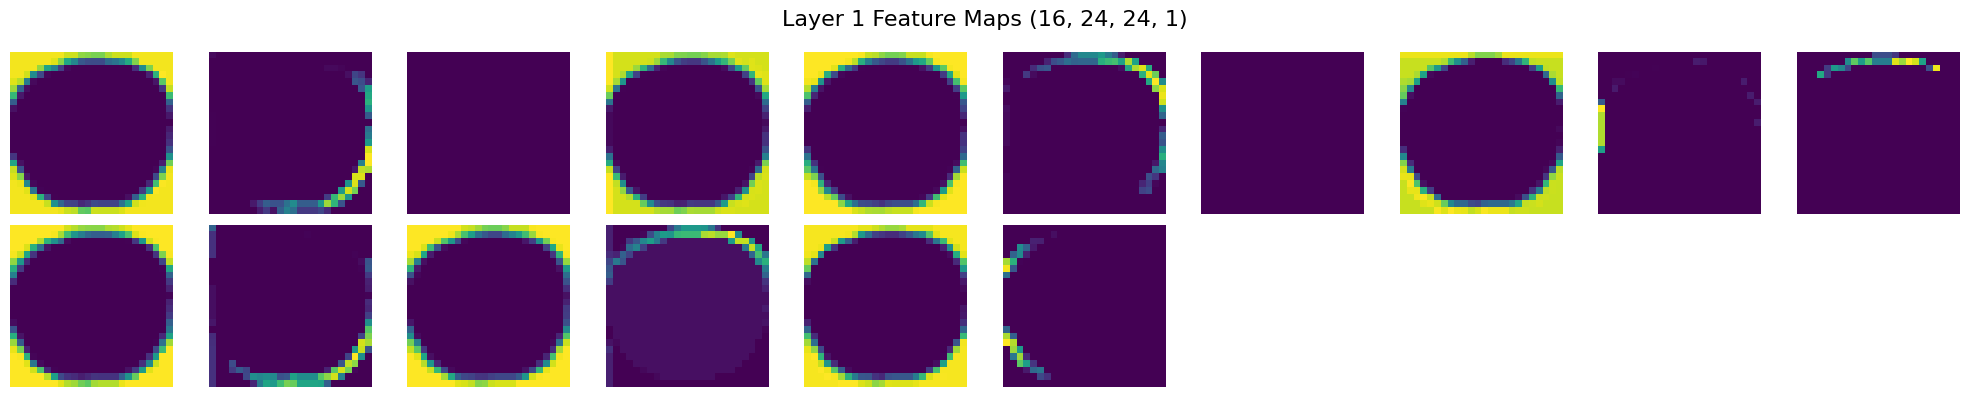

In [ ]:
# plot feature maps

# load trained model
fc_net = FlexiCNN(**model_fc)
fc_net.load_state_dict(fruitCNN_fc_trained)

# get feature maps for an image sample and plot it
# augm_image = shape_transform(data_tensor[np.random.randint(0, len(data_tensor))])
feature_maps = get_feature_maps(fc_net, data_tensor_filled[10])
plot_feature_maps(feature_maps)

#### - 6.6 Model test - testing All Conv CNNnet on augmented image
--- testing model performance on all convolution layes CNN model

In [ ]:
# data augmentation
image_transform = v2.Compose([
    # v2.RandomResizedCrop(224),  # Randomly crops and resizes the image mainly for pretrained model
    v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    # v2.ToPILImage(),  # Convert to PIL Image
    v2.ToImage(),  # Converts the image to a PyTorch tensor and scale to [0 1]
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizes the tensor
    ])

# data split
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.3)
# data augmentation
train_data = customDataset(train_data, train_labels, transform=image_transform)
test_data  = customDataset(test_data, test_labels, transform=None)
# load data for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

# model configueration
model_ac_info = {
    "n_classes": 33,  # number of classes
    "conv_config": [(16, 7, 2, 1), (16, 3, 2, 1), (32, 5, 1, 1), (32, 3, 2, 1),
                    (64, 5, 1, 1), (64, 3, 2, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
    # "pooling": 'max',
    "dropout_rate": 0.1,
    "info": True  # default is False
    }

# create the model
fruitACNN_ac = AconvCNN(**model_ac_info)
# loss function
lossfun = nn.CrossEntropyLoss()
# print model information
print_model_info(fruitACNN_ac, train_loader, lossfun, input_size=(3, 100, 100))


Conv 1 output: torch.Size([64, 16, 48, 48])
Conv 2 output: torch.Size([64, 16, 16, 16])
Conv 3 output: torch.Size([64, 32, 14, 14])
Conv 4 output: torch.Size([64, 32, 5, 5])
Conv 5 output: torch.Size([64, 64, 3, 3])
Conv 6 output: torch.Size([64, 64, 1, 1])
Flattened output: torch.Size([64, 64])
Final output: torch.Size([64, 33])

Model output shape: torch.Size([64, 33])
Target shape: torch.Size([64])

Loss: 3.498453140258789

Model Summary:
Conv 1 output: torch.Size([2, 16, 48, 48])
Conv 2 output: torch.Size([2, 16, 16, 16])
Conv 3 output: torch.Size([2, 32, 14, 14])
Conv 4 output: torch.Size([2, 32, 5, 5])
Conv 5 output: torch.Size([2, 64, 3, 3])
Conv 6 output: torch.Size([2, 64, 1, 1])
Flattened output: torch.Size([2, 64])
Final output: torch.Size([2, 33])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]           2,368
         Dropout2d-2           [-1, 1

Early stopping triggered at 63 epoches


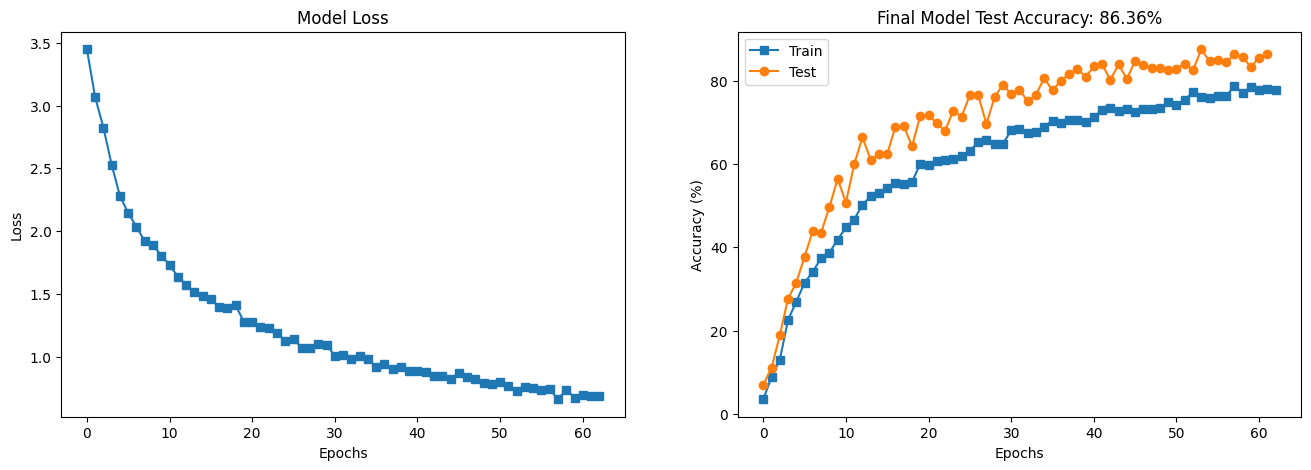

In [ ]:
# Run the data augmentation model
# Create a new configuration with 'info' set to False
model_ac = {**model_ac_info, "info": False}

# create the model
CNN_ac = AconvCNN(**model_ac)

# training configueration
L2lambda = 0.0005
training_config = {
    "optimizer": torch.optim.Adam(CNN_ac.parameters(), lr=0.001, weight_decay=L2lambda),
    "loss_function": nn.CrossEntropyLoss(),
    "num_epochs": 100,
    "patience": 5
    }
# Train the model
net, train_acc, test_acc, losses, final_train_acc, final_test_acc = train_model(
    CNN_ac,
    train_loader,
    test_loader,
    **training_config)

# Save the trianed net
CNN_ac_trained= net.state_dict()

# plot the result
plot_training_results(losses, train_acc, test_acc, final_test_acc)

#### -6.7 Testing on Pre-trianed ResNet-50
--- testing on the benchmark high performance pretrained ResNet-50 model for image classification

In [ ]:
# load pretrained ResNet-50 for fine tuning
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# modify the final output layer to have 33 classes
num_classes = 33
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [ ]:
# set up image trasformation to feed in RestNet-50
ResNet_train = v2.Compose([
    v2.Resize(256, antialias=True),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    # v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    v2.ToImage(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

ResNet_test = v2.Compose([
    v2.Resize(256, antialias=True),
    v2.CenterCrop(224),
    # v2.RandomHorizontalFlip(),  # Randomly flips the image horizontally, default p=0.5
    # v2.RandomVerticalFlip(),    # Randomly flips the image vertically, default p=0.5
    # # v2.RandomRotation(90),      # Randomly rotates the image by up to 30 degrees
    # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly changes brightness, contrast, saturation, and hue
    # v2.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    v2.ToImage(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
# data split
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.3)
# data augmentation
train_data = customDataset(train_data, train_labels, transform=ResNet_train)
test_data  = customDataset(test_data, test_labels, transform=ResNet_test)
# load data for batch training
batchsize    = 128
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=len(test_data))

Epoch [1/5], Loss: 1.2246, Accuracy: 79.4949494949495%
Epoch [2/5], Loss: 0.2221, Accuracy: 95.35353535353535%
Epoch [3/5], Loss: 0.1169, Accuracy: 94.84848484848484%
Epoch [4/5], Loss: 0.1092, Accuracy: 99.1919191919192%
Epoch [5/5], Loss: 0.1337, Accuracy: 88.78787878787878%


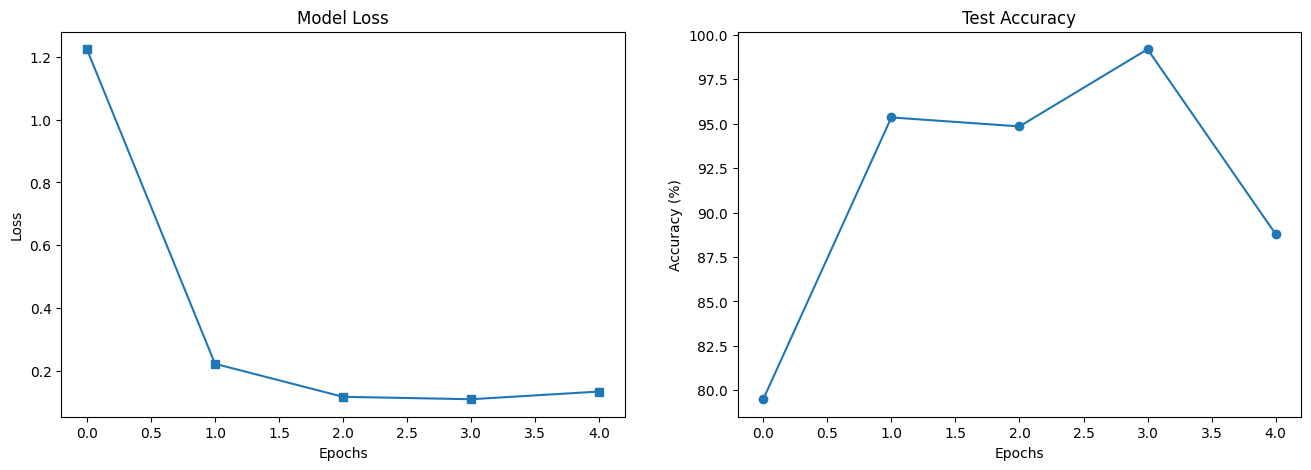

In [ ]:
losses, test_acc = fine_tune_and_evaluate(resnet50, train_loader, test_loader, num_epochs=5)

# plot results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Plot for model losses
ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

# Plot for test accuracy
ax[1].plot(test_acc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Test Accuracy')

plt.show()

### 7. k-Fold CV
--- apply K-fold cross validation to get the final CNN model

In [ ]:
# pick k-Fold CV dataset
cv_data, cv_labels, _ = pick_samples(tot_train_data, tot_train_labels, label_mapping, 300)
# print(modified_label_mapping,'\n')

# data preprocession
# normalization to [0 1]
cv_dataNorm = cv_data / np.max(cv_data)
# move axis 'channel' axis to dimension [0] (CHW means channel Height Width)
cv_dataCHW = np.transpose(cv_dataNorm, (0, 3, 1, 2))

# convert to torch tensor and move 'channel' axis
cv_data_tensor = torch.tensor(cv_dataCHW).float()
cv_labels_tensor = torch.tensor(cv_labels).long()

print(cv_data_tensor.shape)
print(cv_labels_tensor.shape)

torch.Size([9875, 3, 100, 100])
torch.Size([9875])


In [ ]:
# Apply k-Fold CV for final model evaluation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# model configueration
model_kfold = {
    "n_classes": 33,  # number of classes
    "conv_config": [(16, 7, 2, 1), (32, 5, 1, 1), (64, 5, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
    "fc_config": [],  # Fully connected layer sizes
    "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
    "pooling": 'max',
    "dropout_rate": 0.1,
    "info": False  # default is False
    }

# Lists to store results of each fold
results = []
# save final model based on fold test accuracy
best_model_params = None
best_accuracy = 0

for fold, (train_index, dev_index) in enumerate(kfold.split(cv_data_tensor)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # X is image matrix, y is label vector, dev is validation set
    X_train, X_dev = cv_data_tensor[train_index], cv_data_tensor[dev_index]
    y_train, y_dev = cv_labels_tensor[train_index], cv_labels_tensor[dev_index]

    # Apply data augmentation to training data and no augmentation to validation data
    train_dataset = customDataset(X_train, y_train, transform=image_transform)
    dev_dataset = customDataset(X_dev, y_dev, transform=None)

    # Define data loaders for training and validation data in this fold
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
    dev_loader = DataLoader(dev_dataset, batch_size=len(dev_dataset))

    # Instantiate model for each fold
    fruitCNN_kfold = FlexiCNN(**model_kfold)

    # training configueration
    L2lambda = 0.0005
    training_config = {
        "optimizer": torch.optim.Adam(fruitCNN_kfold.parameters(), lr=0.001, weight_decay=L2lambda),
        "loss_function": nn.CrossEntropyLoss(),
        "num_epochs": 100,
        "patience": 5
        }
    # Train the model

    start_time = time.time()  # Record the start time

    net, train_acc, test_acc, losses, final_train_acc, final_val_acc = train_model(
        fruitCNN_kfold,
        train_loader,
        dev_loader,
        **training_config)

    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time  # Calculate the execution time

    print(f"Execution time: {execution_time:.4f} seconds\n")

    # Save the model's performance on this fold
    results.append({'fold': fold, 'final_train_acc': final_train_acc, 'final_val_acc': final_val_acc})

    if final_val_acc > best_accuracy:
        best_accuracy = final_val_acc
        best_model_params = net.state_dict()

# After completing all folds
if best_model_params is not None:
    best_model = FlexiCNN(**model_kfold)
    best_model.load_state_dict(best_model_params)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum_train = 0.0
sum_val = 0.0
for result in results:
    print(f'Fold {result["fold"]}: Train Acc: {result["final_train_acc"]} Val Acc: {result["final_val_acc"]}')
    sum_train += result["final_train_acc"]
    sum_val += result["final_val_acc"]

# Print overall results
print(f'Average Train Accuracy: {sum_train/k_folds}, Average Validation Accuracy: {sum_val/k_folds}')

FOLD 0
--------------------------------
Early stopping triggered at 66 epoches
Execution time: 1872.7194 seconds

FOLD 1
--------------------------------
Early stopping triggered at 66 epoches
Execution time: 1839.8785 seconds

FOLD 2
--------------------------------
Early stopping triggered at 55 epoches
Execution time: 1556.0537 seconds

FOLD 3
--------------------------------
Early stopping triggered at 79 epoches
Execution time: 2186.1913 seconds

FOLD 4
--------------------------------
Early stopping triggered at 69 epoches
Execution time: 1992.2144 seconds

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: Train Acc: 96.51639344262296 Val Acc: 97.9746835443038
Fold 1: Train Acc: 96.65727459016394 Val Acc: 97.9240506329114
Fold 2: Train Acc: 96.49077868852459 Val Acc: 96.0
Fold 3: Train Acc: 97.07991803278688 Val Acc: 97.0126582278481
Fold 4: Train Acc: 96.70850409836066 Val Acc: 98.27848101265822
Average Train Accuracy: 96.6905737704918, Average

### 8. Final Evaluation

In [ ]:
# prepare the reserved data to proper type for evaluation

# normalization to [0 1]
reserved_dataNorm = reserved_data / np.max(reserved_data)
# move axis 'channel' axis to dimension [0] (CHW means channel Height Width)
reserved_dataCHW = np.transpose(reserved_dataNorm, (0, 3, 1, 2))

# convert to torch tensor and move 'channel' axis
reserved_data_tensor = torch.tensor(reserved_dataCHW).float()
reserved_labels_tensor = torch.tensor(reserved_labels).long()

print(reserved_data_tensor.shape)
print(reserved_labels_tensor.shape)

# convert to TensorDataset
final_test_data  = torch.utils.data.TensorDataset(reserved_data_tensor,reserved_labels_tensor)
# send to DataLoader for batch training
final_test_loader = DataLoader(final_test_data,batch_size=128,shuffle=False)

torch.Size([5057, 3, 100, 100])
torch.Size([5057])


In [ ]:
# Set the model in evaluation mode
best_model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No need to track gradients for this evaluation
with torch.no_grad():
    for X_test, y_test in final_test_loader:  # Assuming test_loader is already defined and is for the test dataset
        # Forward pass through the model to get predictions
        y_test_hat = best_model(X_test)

        # Get the class predictions
        _, predicted_labels = torch.max(y_test_hat, 1)

        # Append the labels and predictions to the lists
        true_labels.extend(y_test.tolist())
        predictions.extend(predicted_labels.tolist())

# Compute the accuracy or other metrics using the true labels and predictions
test_accuracy = accuracy_score(true_labels, predictions) * 100
final_accuracy = round(test_accuracy, 2)
print(f'The Final Test Accuracy on Reserved Data : {final_accuracy}%')

The Final Test Accuracy on Reserved Data : 97.35%


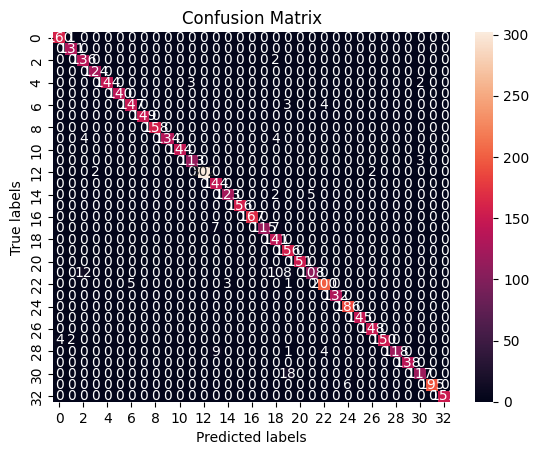

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Visualize the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the state dictionary for future use
torch.save(best_model.state_dict(), 'fruit_model_state_dict.pth')

# # load the data for future use
# # model configueration
# model_config = {
#     "n_classes": 33,  # number of classes
#     "conv_config": [(16, 7, 2, 1), (32, 5, 1, 1), (64, 5, 1, 1)],  # Conv layer (filters, kernel_size, stride, padding)
#     "fc_config": [],  # Fully connected layer sizes
#     "input_size": (3, 100, 100),  # input images size default is (3, 244, 244)
#     "pooling": 'max',
#     "dropout_rate": 0.1,
#     "info": False  # default is False
#     }

# model = FlexiCNN(**model_config)  # Instantiate the model with the same arguments as before
# model.load_state_dict(torch.load('fruit_model_state_dict.pth'))
# model.eval()  # Set the model to evaluation mode